# Setup

In [1]:
import numpy as np
from numpy import array
from numpy import pi
import matplotlib.pyplot as plt
# from pycqed.analysis_v2.base_analysis import BaseDataAnalysis
from pycqed.analysis import analysis_toolbox as a_tools
from pycqed.analysis import measurement_analysis as ma
from pycqed.analysis_v2 import readout_analysis as ra
from pycqed.analysis_v2 import timedomain_analysis as tda
import os
import matplotlib
import matplotlib.colors as mc
import itertools
from importlib import reload
import h5py
from  datetime import datetime
from copy import deepcopy
from numpy import pi
# matplotlib.rcParams.update({'font.size': 20})
a_tools.datadir = "Q:\\USERS\\nathan\\data\\thesis_data"
figsave_base = "C:\\Users\\nathan\\projects\\master_thesis\\chapters\\carb_gate\\figs\\"


c:\users\nathan\code\quantumsoftware\pycqed_py3\data
Data directory set to: c:\users\nathan\code\quantumsoftware\pycqed_py3\data


## Define plotting style

In [2]:
fig_size_dim    = 8
golden_ratio    = (1+np.sqrt(5))/2
fig_size        = (fig_size_dim, fig_size_dim/golden_ratio)
def plot_style():
    font_size       = 16
    marker_size     = 6
    line_width      = 2.5
    axes_line_width = 1
    tick_length     = 5
    tick_width      = 1
    tick_color      = 'k'
    ticks_direction = 'in'
    axes_labelcolor = 'k'

    
    dpi             =  300

    params = {'figure.figsize': fig_size,
              'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "DIN Pro",#"cmss10", #"DINPro", # to manage to use dinpro, put ttf files in site-packages/matplotlib/mpl-data/fonts
              'mathtext.default': 'it',
              'mathtext.fontset': "cm",
              'mathtext.it': 'cm',
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.labelcolor': axes_labelcolor,
              'axes.titlesize': font_size,
              'axes.linewidth': axes_line_width,
              'lines.markersize': marker_size,
              'lines.linewidth': line_width,
              'xtick.direction': ticks_direction,
              'ytick.direction': ticks_direction,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'xtick.color': tick_color,
              'ytick.color': tick_color,
              'xtick.major.size': tick_length,
              'ytick.major.size': tick_length,
              'xtick.major.width': tick_width,
              'ytick.major.width': tick_width,
              'xtick.top': True,
              'xtick.bottom': True,
              'ytick.left': True,
              'ytick.right': True,
              'axes.formatter.useoffset': False,
              'pdf.fonttype' : 42, 
              'ps.fonttype' : 42,
              # LEGEND
            'legend.loc'           : 'best',
            'legend.frameon'       : False,     ## if True, draw the legend on a background patch
    #         'legend.framealpha'    : 0.8,      ## legend patch transparency
    #         'legend.facecolor'     : 'inherit',  ## inherit from axes.facecolor; or color spec
    #         'legend.edgecolor'     : 0.8,      ## background patch boundary color
    #         'legend.fancybox'      : True,     ## if True, use a rounded box for the
                                             ## legend background, else a rectangle
                }

    plt.rcParams.update(params)
def get_color_list(N, base_cmap=None):
    base = plt.cm.get_cmap(base_cmap)
    return base(np.linspace(0, 1, N))

def plot_colormesh(xx, yy, zz, ax=None, labels=True, colorbar=True, **plot_kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    plot_kwargs = deepcopy(plot_kwargs)
    vmin = plot_kwargs.pop("vmin", -1)
    vmax = plot_kwargs.pop("vmax", 1)
    cmap = plot_kwargs.pop("cmap", "seismic")
    im = ax.pcolormesh(np.pad(xx,(1,0), "linear_ramp"), np.pad(yy,(1,0), "linear_ramp"), zz, 
                       cmap=cmap, vmin=vmin, vmax=vmax, 
                       **plot_kwargs)
    if labels:
        ax.set_xlabel("gamma (rad.)")
        ax.set_ylabel("beta (rad.)")
    if colorbar:
        cb = fig.colorbar(im, label=r"$\sigma_z \sigma_z$ (arb. u.)")
    return im

plot_style()
# search fonts
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [3]:
"""
===========
Basic Units, used to display axis in units of pi
===========

"""

import math

import numpy as np

import matplotlib.units as units
import matplotlib.ticker as ticker


class ProxyDelegate(object):
    def __init__(self, fn_name, proxy_type):
        self.proxy_type = proxy_type
        self.fn_name = fn_name

    def __get__(self, obj, objtype=None):
        return self.proxy_type(self.fn_name, obj)


class TaggedValueMeta(type):
    def __init__(self, name, bases, dict):
        for fn_name in self._proxies:
            try:
                dummy = getattr(self, fn_name)
            except AttributeError:
                setattr(self, fn_name,
                        ProxyDelegate(fn_name, self._proxies[fn_name]))


class PassThroughProxy(object):
    def __init__(self, fn_name, obj):
        self.fn_name = fn_name
        self.target = obj.proxy_target

    def __call__(self, *args):
        fn = getattr(self.target, self.fn_name)
        ret = fn(*args)
        return ret


class ConvertArgsProxy(PassThroughProxy):
    def __init__(self, fn_name, obj):
        PassThroughProxy.__init__(self, fn_name, obj)
        self.unit = obj.unit

    def __call__(self, *args):
        converted_args = []
        for a in args:
            try:
                converted_args.append(a.convert_to(self.unit))
            except AttributeError:
                converted_args.append(TaggedValue(a, self.unit))
        converted_args = tuple([c.get_value() for c in converted_args])
        return PassThroughProxy.__call__(self, *converted_args)


class ConvertReturnProxy(PassThroughProxy):
    def __init__(self, fn_name, obj):
        PassThroughProxy.__init__(self, fn_name, obj)
        self.unit = obj.unit

    def __call__(self, *args):
        ret = PassThroughProxy.__call__(self, *args)
        return (NotImplemented if ret is NotImplemented
                else TaggedValue(ret, self.unit))


class ConvertAllProxy(PassThroughProxy):
    def __init__(self, fn_name, obj):
        PassThroughProxy.__init__(self, fn_name, obj)
        self.unit = obj.unit

    def __call__(self, *args):
        converted_args = []
        arg_units = [self.unit]
        for a in args:
            if hasattr(a, 'get_unit') and not hasattr(a, 'convert_to'):
                # if this arg has a unit type but no conversion ability,
                # this operation is prohibited
                return NotImplemented

            if hasattr(a, 'convert_to'):
                try:
                    a = a.convert_to(self.unit)
                except Exception:
                    pass
                arg_units.append(a.get_unit())
                converted_args.append(a.get_value())
            else:
                converted_args.append(a)
                if hasattr(a, 'get_unit'):
                    arg_units.append(a.get_unit())
                else:
                    arg_units.append(None)
        converted_args = tuple(converted_args)
        ret = PassThroughProxy.__call__(self, *converted_args)
        if ret is NotImplemented:
            return NotImplemented
        ret_unit = unit_resolver(self.fn_name, arg_units)
        if ret_unit is NotImplemented:
            return NotImplemented
        return TaggedValue(ret, ret_unit)


class TaggedValue(metaclass=TaggedValueMeta):

    _proxies = {'__add__': ConvertAllProxy,
                '__sub__': ConvertAllProxy,
                '__mul__': ConvertAllProxy,
                '__rmul__': ConvertAllProxy,
                '__cmp__': ConvertAllProxy,
                '__lt__': ConvertAllProxy,
                '__gt__': ConvertAllProxy,
                '__len__': PassThroughProxy}

    def __new__(cls, value, unit):
        # generate a new subclass for value
        value_class = type(value)
        try:
            subcls = type(f'TaggedValue_of_{value_class.__name__}',
                          (cls, value_class), {})
            if subcls not in units.registry:
                units.registry[subcls] = basicConverter
            return object.__new__(subcls)
        except TypeError:
            if cls not in units.registry:
                units.registry[cls] = basicConverter
            return object.__new__(cls)

    def __init__(self, value, unit):
        self.value = value
        self.unit = unit
        self.proxy_target = self.value

    def __getattribute__(self, name):
        if name.startswith('__'):
            return object.__getattribute__(self, name)
        variable = object.__getattribute__(self, 'value')
        if hasattr(variable, name) and name not in self.__class__.__dict__:
            return getattr(variable, name)
        return object.__getattribute__(self, name)

    def __array__(self, dtype=object):
        return np.asarray(self.value).astype(dtype)

    def __array_wrap__(self, array, context):
        return TaggedValue(array, self.unit)

    def __repr__(self):
        return 'TaggedValue({!r}, {!r})'.format(self.value, self.unit)

    def __str__(self):
        return str(self.value) + ' in ' + str(self.unit)

    def __len__(self):
        return len(self.value)

    def __iter__(self):
        # Return a generator expression rather than use `yield`, so that
        # TypeError is raised by iter(self) if appropriate when checking for
        # iterability.
        return (TaggedValue(inner, self.unit) for inner in self.value)

    def get_compressed_copy(self, mask):
        new_value = np.ma.masked_array(self.value, mask=mask).compressed()
        return TaggedValue(new_value, self.unit)

    def convert_to(self, unit):
        if unit == self.unit or not unit:
            return self
        try:
            new_value = self.unit.convert_value_to(self.value, unit)
        except AttributeError:
            new_value = self
        return TaggedValue(new_value, unit)

    def get_value(self):
        return self.value

    def get_unit(self):
        return self.unit


class BasicUnit(object):
    def __init__(self, name, fullname=None):
        self.name = name
        if fullname is None:
            fullname = name
        self.fullname = fullname
        self.conversions = dict()

    def __repr__(self):
        return f'BasicUnit({self.name})'

    def __str__(self):
        return self.fullname

    def __call__(self, value):
        return TaggedValue(value, self)

    def __mul__(self, rhs):
        value = rhs
        unit = self
        if hasattr(rhs, 'get_unit'):
            value = rhs.get_value()
            unit = rhs.get_unit()
            unit = unit_resolver('__mul__', (self, unit))
        if unit is NotImplemented:
            return NotImplemented
        return TaggedValue(value, unit)

    def __rmul__(self, lhs):
        return self*lhs

    def __array_wrap__(self, array, context):
        return TaggedValue(array, self)

    def __array__(self, t=None, context=None):
        ret = np.array([1])
        if t is not None:
            return ret.astype(t)
        else:
            return ret

    def add_conversion_factor(self, unit, factor):
        def convert(x):
            return x*factor
        self.conversions[unit] = convert

    def add_conversion_fn(self, unit, fn):
        self.conversions[unit] = fn

    def get_conversion_fn(self, unit):
        return self.conversions[unit]

    def convert_value_to(self, value, unit):
        conversion_fn = self.conversions[unit]
        ret = conversion_fn(value)
        return ret

    def get_unit(self):
        return self


class UnitResolver(object):
    def addition_rule(self, units):
        for unit_1, unit_2 in zip(units[:-1], units[1:]):
            if unit_1 != unit_2:
                return NotImplemented
        return units[0]

    def multiplication_rule(self, units):
        non_null = [u for u in units if u]
        if len(non_null) > 1:
            return NotImplemented
        return non_null[0]

    op_dict = {
        '__mul__': multiplication_rule,
        '__rmul__': multiplication_rule,
        '__add__': addition_rule,
        '__radd__': addition_rule,
        '__sub__': addition_rule,
        '__rsub__': addition_rule}

    def __call__(self, operation, units):
        if operation not in self.op_dict:
            return NotImplemented

        return self.op_dict[operation](self, units)


unit_resolver = UnitResolver()

cm = BasicUnit('cm', 'centimeters')
inch = BasicUnit('inch', 'inches')
inch.add_conversion_factor(cm, 2.54)
cm.add_conversion_factor(inch, 1/2.54)

radians = BasicUnit('rad', 'radians')
degrees = BasicUnit('deg', 'degrees')
radians.add_conversion_factor(degrees, 180.0/np.pi)
degrees.add_conversion_factor(radians, np.pi/180.0)

secs = BasicUnit('s', 'seconds')
hertz = BasicUnit('Hz', 'Hertz')
minutes = BasicUnit('min', 'minutes')

secs.add_conversion_fn(hertz, lambda x: 1./x)
secs.add_conversion_factor(minutes, 1/60.0)


# radians formatting
def rad_fn(x, pos=None):
    if x >= 0:
        n = int((x / np.pi) * 2.0 + 0.25)
    else:
        n = int((x / np.pi) * 2.0 - 0.25)

    if n == 0:
        return '0'
    elif n == 1:
        return r'$\pi/2$'
    elif n == 2:
        return r'$\pi$'
    elif n == -1:
        return r'$-\pi/2$'
    elif n == -2:
        return r'$-\pi$'
    elif n % 2 == 0:
        return fr'${n//2}\pi$'
    else:
        return fr'${n}\pi/2$'


class BasicUnitConverter(units.ConversionInterface):
    @staticmethod
    def axisinfo(unit, axis):
        'return AxisInfo instance for x and unit'

        if unit == radians:
            return units.AxisInfo(
                majloc=ticker.MultipleLocator(base=np.pi/2),
                majfmt=ticker.FuncFormatter(rad_fn),
                label=unit.fullname,
            )
        elif unit == degrees:
            return units.AxisInfo(
                majloc=ticker.AutoLocator(),
                majfmt=ticker.FormatStrFormatter(r'$%i^\circ$'),
                label=unit.fullname,
            )
        elif unit is not None:
            if hasattr(unit, 'fullname'):
                return units.AxisInfo(label=unit.fullname)
            elif hasattr(unit, 'unit'):
                return units.AxisInfo(label=unit.unit.fullname)
        return None

    @staticmethod
    def convert(val, unit, axis):
        if units.ConversionInterface.is_numlike(val):
            return val
        if np.iterable(val):
            if isinstance(val, np.ma.MaskedArray):
                val = val.astype(float).filled(np.nan)
            out = np.empty(len(val))
            for i, thisval in enumerate(val):
                if np.ma.is_masked(thisval):
                    out[i] = np.nan
                else:
                    try:
                        out[i] = thisval.convert_to(unit).get_value()
                    except AttributeError:
                        out[i] = thisval
            return out
        if np.ma.is_masked(val):
            return np.nan
        else:
            return val.convert_to(unit).get_value()

    @staticmethod
    def default_units(x, axis):
        'return the default unit for x or None'
        if np.iterable(x):
            for thisx in x:
                return thisx.unit
        return x.unit


def cos(x):
    if np.iterable(x):
        return [math.cos(val.convert_to(radians).get_value()) for val in x]
    else:
        return math.cos(x.convert_to(radians).get_value())


basicConverter = BasicUnitConverter()
units.registry[BasicUnit] = basicConverter
units.registry[TaggedValue] = basicConverter


## Fake init

In [17]:
from pycqed.measurement import calibration_points as c_p
from pycqed.measurement.waveform_control import pulsar as ps
from pycqed.measurement.waveform_control import segment as sg
import time
t0 = time.time()  # to print how long init takes
import logging
from pprint import pprint

import collections
odict = collections.OrderedDict

import os; os.environ['PYGSTI_BACKCOMPAT_WARNING'] = '0'
import qutip as qtp

# Qcodes
import sys
import qcodes as qc

# makes sure logging messages show up in the notebook
log = logging.getLogger()
log.addHandler(logging.StreamHandler())

# Import a_tools first so that the datadir is correct in other modules that
# import it.
from pycqed.analysis import analysis_toolbox as a_tools


# General PycQED modules
from pycqed.utilities import general as gen
from pycqed.measurement import measurement_control as mc
from pycqed.measurement import detector_functions as det
from pycqed.measurement import sweep_functions as swf
from pycqed.measurement.waveform_control import pulsar as ps
from pycqed.measurement import awg_sweep_functions as awg_swf
from pycqed.measurement import awg_sweep_functions_multi_qubit as awg_swf2
from pycqed.analysis import measurement_analysis as ma
from pycqed.analysis_v2 import base_analysis as ba

from pycqed.analysis_v2 import readout_analysis as ra
from pycqed.analysis_v2 import timedomain_analysis as tda
from pycqed.analysis_v2 import tomography_qudev as tomo
from pycqed.measurement import multi_qubit_module as mqm

# Instrument drivers
from qcodes.instrument_drivers.rohde_schwarz import SGS100A as rs
from qcodes.instrument_drivers.stanford_research import SIM928 as srs
from qcodes.instrument_drivers.tektronix import AWG5014 as tek
from pycqed.instrument_drivers.virtual_instruments import virtual_awg5014, virtual_RSSGS100A, virtual_AWG8
from pycqed.instrument_drivers.meta_instrument.qubit_objects.QuDev_transmon \
    import QuDev_transmon, add_CZ_pulse
#from pycqedscripts.drivers import conversion_box_control as cbc
from pycqed.instrument_drivers.meta_instrument import TWPA as twpa_module
# from pycqed.instrument_drivers.physical_instruments.ZurichInstruments \
#     import UHFQuantumController as ziuhfqa
from pycqed.instrument_drivers.physical_instruments.ZurichInstruments \
    import dummy_UHFQC as ziuhfqa

from IPython.display import clear_output

###############################################################################
########################### Instrument creation ###############################
###############################################################################

station = qc.Station()
qc.station = station
MWG2 = virtual_RSSGS100A.virtualRohdeSchwarz_SGS100A(name='MWG2', address='TCPIP0::192.168.1.32')
MWG4 = virtual_RSSGS100A.virtualRohdeSchwarz_SGS100A(name='MWG4', address='TCPIP0::192.168.1.34')
MWG5 = virtual_RSSGS100A.virtualRohdeSchwarz_SGS100A(name='MWG5', address='TCPIP0::192.168.1.35')
MWG6 = virtual_RSSGS100A.virtualRohdeSchwarz_SGS100A(name='MWG6', address='TCPIP0::192.168.1.36')
MWG7 = virtual_RSSGS100A.virtualRohdeSchwarz_SGS100A(name='MWG7', address='TCPIP0::192.168.1.37')
MWG8 = virtual_RSSGS100A.virtualRohdeSchwarz_SGS100A(name='MWG8', address='TCPIP0::192.168.1.38')
MWG9 = virtual_RSSGS100A.virtualRohdeSchwarz_SGS100A(name='MWG9', address='TCPIP0::192.168.1.39')
AWG1 = virtual_awg5014.VirtualAWG5014(name='AWG1', timeout=20,
                             address='TCPIP0::192.168.1.4')
AWG2 = virtual_awg5014.VirtualAWG5014(name='AWG2', timeout=20,
                             address='TCPIP0::192.168.1.5')
AWG8 = virtual_AWG8.VirtualAWG8('AWG8')
# UHF = ziuhfqa.dummy_UHFQC('UHF', device='dev2249', port=8004, interface='1GbE')
UHF = ziuhfqa.dummy_UHFQC('UHF')


MC = mc.MeasurementControl('MC')
MC.datadir("Q:\\USERS\\nathan\\data")
pulsar = ps.Pulsar('Pulsar')

"UHFQuantumController" not imported.
"UHFQuantumController" not imported.
"readout_mode_simulations_for_CLEAR_pulse" not imported.


c:\users\nathan\code\quantumsoftware\pycqed_py3\data
Initialized dummy UHFQC UHF in 0.01s


In [18]:
station.add_component(MC)
station.add_component(pulsar)
station.add_component(MWG2)
station.add_component(MWG4)
station.add_component(MWG5)
station.add_component(MWG6)
station.add_component(MWG7)
station.add_component(MWG8)
station.add_component(MWG9)
station.add_component(UHF, update_snapshot=False)
station.add_component(AWG1, update_snapshot=False)
station.add_component(AWG2, update_snapshot=False)
station.pulsar = pulsar

delays = {
    'AWG1': 0,
    'AWG2': 124*4/1.2e9,
    'AWG3': 125*4/1.2e9,
    'AWG8': 43*8/2.4e9,
    'UHF': 54*4/1.2e9,
}

trigger_channel_map = {
    'AWG1': [],
    'AWG2': ['AWG1_ch1m1'],
    'UHF': ['AWG1_ch4m1'],
    'AWG8': ['AWG1_ch2m1', 'AWG1_ch2m2', 'AWG1_ch3m1', 'AWG1_ch3m2']
}

offset_mode = {
    'AWG1': 'hardware',
    'AWG2': 'software',
    'AWG3': 'software',
}
for AWG in [AWG1, AWG2, AWG8, UHF]:
    pulsar.define_awg_channels(AWG)
    pulsar.set('{}_delay'.format(AWG.name), delays[AWG.name])
    pulsar.set('{}_compensation_pulse_min_length'.format(AWG.name), 4/(1.2e9))
    pulsar.set('{}_active'.format(AWG.name), True)
    pulsar.set('{}_trigger_channels'.format(AWG.name),
               trigger_channel_map[AWG.name])

    if isinstance(AWG, virtual_awg5014.VirtualAWG5014):
        for i in range(1, 5):
            pulsar.set('{}_ch{}_offset_mode'.format(AWG.name, i),
                       offset_mode[AWG.name])
            pulsar.set('{}_ch{}_amp'.format(AWG.name, i), 2)
            pulsar.set('{}_ch{}m1_amp'.format(AWG.name, i), 2.7)
            pulsar.set('{}_ch{}m2_amp'.format(AWG.name, i), 2.7)
            pulsar.set('{}_ch{}_offset'.format(AWG.name, i), 0)
            pulsar.set('{}_ch{}m1_offset'.format(AWG.name, i), 0)
            pulsar.set('{}_ch{}m2_offset'.format(AWG.name, i), 0)
    elif isinstance(AWG, virtual_AWG8.VirtualAWG8):
        for ch in pulsar.find_awg_channels(AWG.name):
            cid = pulsar.get(ch + '_id')
            AWG.set('sigouts_{}_direct'.format(int(cid[2]) - 1), 0)
            pulsar.set('{}_amp'.format(ch), 2.5)
            AWG.set('sigouts_{}_on'.format(int(cid[2]) - 1), True)
#             AWG._dev.seti('sines/{}/enables/0'.format(int(cid[2]) - 1), 0)
#             AWG._dev.seti('sines/{}/enables/1'.format(int(cid[2]) - 1), 0)
            AWG.set('triggers_in_{}_imp50'.format(int(cid[2]) - 1), 1)
            AWG.set('triggers_in_{}_level'.format(int(cid[2]) - 1), 0.5)
#         AWG._dev.seti('system/clocks/referenceclock/source', 1)
        for awg_nr in range(4):
            # First the DIO input (same as seen by HDAWG.awgs_0_dio_data() 
            # parameter) is bit shifted to the right by 
            # HDAWG.awgs_0_dio_mask_shift() bits. Then it is bitwise ANDed with 
            # HDAWG.awgs_0_dio_mask_value(). The result is what the playWaveDIO() 
            # command in the awg sequencer sees.
            AWG.set('awgs_{}_dio_mask_value'.format(awg_nr), 1)
            AWG.set('awgs_{}_dio_mask_shift'.format(awg_nr), 1)
            # The UHF outputs a 25MHz signal on pin 15
            AWG.set('awgs_{}_dio_strobe_index'.format(awg_nr), 15)
            # 1: rising edge, 2: falling edge or 3: both edges
            AWG.set('awgs_{}_dio_strobe_slope'.format(awg_nr), 3)
            # Choose any pin here
            AWG.set('awgs_{}_dio_valid_index'.format(awg_nr), 0)
            # 0: no valid bit needed, 1: low, 2: high
            AWG.set('awgs_{}_dio_valid_polarity'.format(awg_nr), 0)
            AWG.set('awgs_{}_auxtriggers_0_channel'.format(awg_nr),
                    2 * awg_nr + 1 - (awg_nr % 2))
            AWG.set('awgs_{}_auxtriggers_0_slope'.format(awg_nr), 1)
            
from pycqed.instrument_drivers.meta_instrument.qubit_objects.QuDev_transmon import QuDev_transmon
from pycqed.measurement import measurement_control as mc
from pycqed.measurement.waveform_control import segment as segm
from pycqed.measurement.waveform_control import sequence as sequ
from pycqed.measurement.pulse_sequences import single_qubit_tek_seq_elts as sqs

qb1 = QuDev_transmon('qb1')
qb2 = QuDev_transmon('qb2')
qb3 = QuDev_transmon('qb3')
qb4 = QuDev_transmon('qb4')

qubits = [qb1, qb2, qb3, qb4]
for qb in qubits:
    qb.instr_mc('MC')
    qb.instr_uhf('UHF')
    qb.ro_I_channel('UHF_ch1')
    qb.ro_Q_channel('UHF_ch2')

# create two qb gates 
from pycqed.instrument_drivers.meta_instrument.qubit_objects import QuDev_transmon as QdvTrmn

# add two qb gates
QdvTrmn.add_CZ_pulse(qb1, qb2)
QdvTrmn.add_CZ_pulse(qb3, qb2)
QdvTrmn.add_CZ_pulse(qb4, qb3)
upcz_pulse_names = dict()

Snapshot: Could not update parameter: frequency on MWG2
Snapshot: Could not update parameter: phase on MWG2
Snapshot: Could not update parameter: power on MWG2
Snapshot: Could not update parameter: status on MWG2
Snapshot: Could not update parameter: pulsemod_state on MWG2
Snapshot: Could not update parameter: frequency on MWG4
Snapshot: Could not update parameter: phase on MWG4
Snapshot: Could not update parameter: power on MWG4
Snapshot: Could not update parameter: status on MWG4
Snapshot: Could not update parameter: pulsemod_state on MWG4
Snapshot: Could not update parameter: frequency on MWG5
Snapshot: Could not update parameter: phase on MWG5
Snapshot: Could not update parameter: power on MWG5
Snapshot: Could not update parameter: status on MWG5
Snapshot: Could not update parameter: pulsemod_state on MWG5
Snapshot: Could not update parameter: frequency on MWG6
Snapshot: Could not update parameter: phase on MWG6
Snapshot: Could not update parameter: power on MWG6
Snapshot: Could no

### Load parameters

In [8]:

import pycqed.utilities.general as gen
timestamp = None
#Import from timestamp
timestamp = '20191208_151620' # hw
# timestamp = "20191207_221812"# chevron 
for qb in qubits:
    gen.load_settings(qb, timestamp=timestamp)
    
clear_output()


## 1 D plot

### Colormap crap

In [4]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors

def gradient_collection(x, y, ax, reverse_colors=False, cmap=None):
    if cmap is None:
        cmap ='viridis'
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    # print(points.shape)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(deltas.min(), deltas.max())
    lc = LineCollection(segments, cmap=cmap, norm=norm)
# Set the values used for colormapping
    if reverse_colors:
        lc.set_array(-deltas)
    else:
        lc.set_array(deltas)
    line = ax.add_collection(lc)
    return line
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


In [5]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)


import matplotlib.colors as col
import seaborn as sns
import hsluv # install via pip
import scipy.special # just for the example function

##### generate custom colormaps
def make_segmented_cmap(): 
    white = '#ffffff'
    black = '#800080'
    red = '#ff0000'
    blue = '#0000ff'
    anglemap = col.LinearSegmentedColormap.from_list(
        'anglemap', [black, red, white, blue, black], N=256, gamma=1)
    return anglemap

def make_anglemap( N = 256, use_hpl = True ):
    h = np.ones(N) # hue
    h[:N//2] = 11.6 # red 
    h[N//2:] = 258.6 # blue
    s = 100 # saturation
    l = np.linspace(0, 100, N//2) # luminosity
    l = np.hstack( (l,l[::-1] ) )

    colorlist = np.zeros((N,3))
    for ii in range(N):
        if use_hpl:
            colorlist[ii,:] = hsluv.hpluv_to_rgb( (h[ii], s, l[ii]) )
        else:
            colorlist[ii,:] = hsluv.hsluv_to_rgb( (h[ii], s, l[ii]) )
    colorlist[colorlist > 1] = 1 # correct numeric errors
    colorlist[colorlist < 0] = 0 
    return col.ListedColormap( colorlist )
def interpolate_color(start_color, end_color, ncolors=50):
    start_color = np.array(start_color)
    end_color = np.array(end_color) 
    diff = end_color - start_color
    
    interp_colors = []
    for i in range(ncolors+1):
        interp_colors.append(list(abs(start_color + i*diff/ncolors)))
    return interp_colors
# N = 256
# segmented_cmap = make_segmented_cmap()
# flat_huslmap = col.ListedColormap(sns.color_palette('husl',N))
# hsluv_anglemap = make_anglemap( use_hpl = False )
# hpluv_anglemap = make_anglemap( use_hpl = True )

# ##### generate data grid
# x = np.linspace(-2,2,N)
# y = np.linspace(-2,2,N)
# z = np.zeros((len(y),len(x))) # make cartesian grid
# for ii in range(len(y)): 
#     z[ii] = np.arctan2(y[ii],x) # simple angular function
#     z[ii] = np.angle(scipy.special.gamma(x+1j*y[ii])) # some complex function

# ##### plot with different colormaps
# fig = plt.figure(1)
# fig.clf()
# colormapnames = ['segmented map', 'hue-HUSL', 'lum-HSLUV', 'lum-HPLUV']
# colormaps = [segmented_cmap, flat_huslmap, hsluv_anglemap, hpluv_anglemap]
# for ii, cm in enumerate(colormaps):
#     ax = fig.add_subplot(2, 2, ii+1)
#     pmesh = ax.pcolormesh(x, y, z/np.pi, 
#         cmap = cm, vmin=-1, vmax=1)
#     plt.axis([x.min(), x.max(), y.min(), y.max()])
#     cbar = fig.colorbar(pmesh)
#     cbar.ax.set_ylabel('Phase [pi]')
#     ax.set_title( colormapnames[ii] )
# plt.show()

In [13]:
from copy import deepcopy
cmap = deepcopy(plt.get_cmap('gist_heat'))
cmap(0) # this stupid line is necessary to create the lut
# print(cmap.__dict__)
print(len(cmap._lut))

n = 80
cmap._lut = cmap._lut[n:]
cmap.N = 256 - n
cmap._i_under = cmap._i_under -n
cmap._i_over = cmap._i_over -n
cmap._i_bad = cmap._i_bad -n
cmap_chevron = cmap
# print(cmap.__dict__)
# print(len(cmap._lut))

259


In [14]:
cmap2 = deepcopy(plt.get_cmap('twilight_shifted'))
# print(cmap2.__dict__)
# print(len(cmap._lut))

n = 70
ncolors = len(cmap2.colors)
colors = list(cmap2.colors[:ncolors//2-n]) \
            + interpolate_color(cmap2.colors[:ncolors//2-n][-1], (1,1,1), n) \
    + interpolate_color( (1,1,1), cmap2.colors[ncolors//2+n:][0], n) \
            + list(cmap2.colors[ncolors//2+n:])

n2 = 30
ncolors = len(cmap2.colors)
colors =  interpolate_color((0,0,0), colors[n2], n2) + list(colors[n2:-n2]) \
    + interpolate_color(  colors[-n2], (0,0,0), n2) 

cmap_phase = mcolors.LinearSegmentedColormap.from_list(
        'anglemap', colors, gamma=1)
# cmap2.N = 256 - n
# cmap2._i_under = cmap2._i_under -n
# cmap2._i_over = cmap2._i_over -n
# cmap2._i_bad = cmap2._i_bad -n
# print(cmap.__dict__)

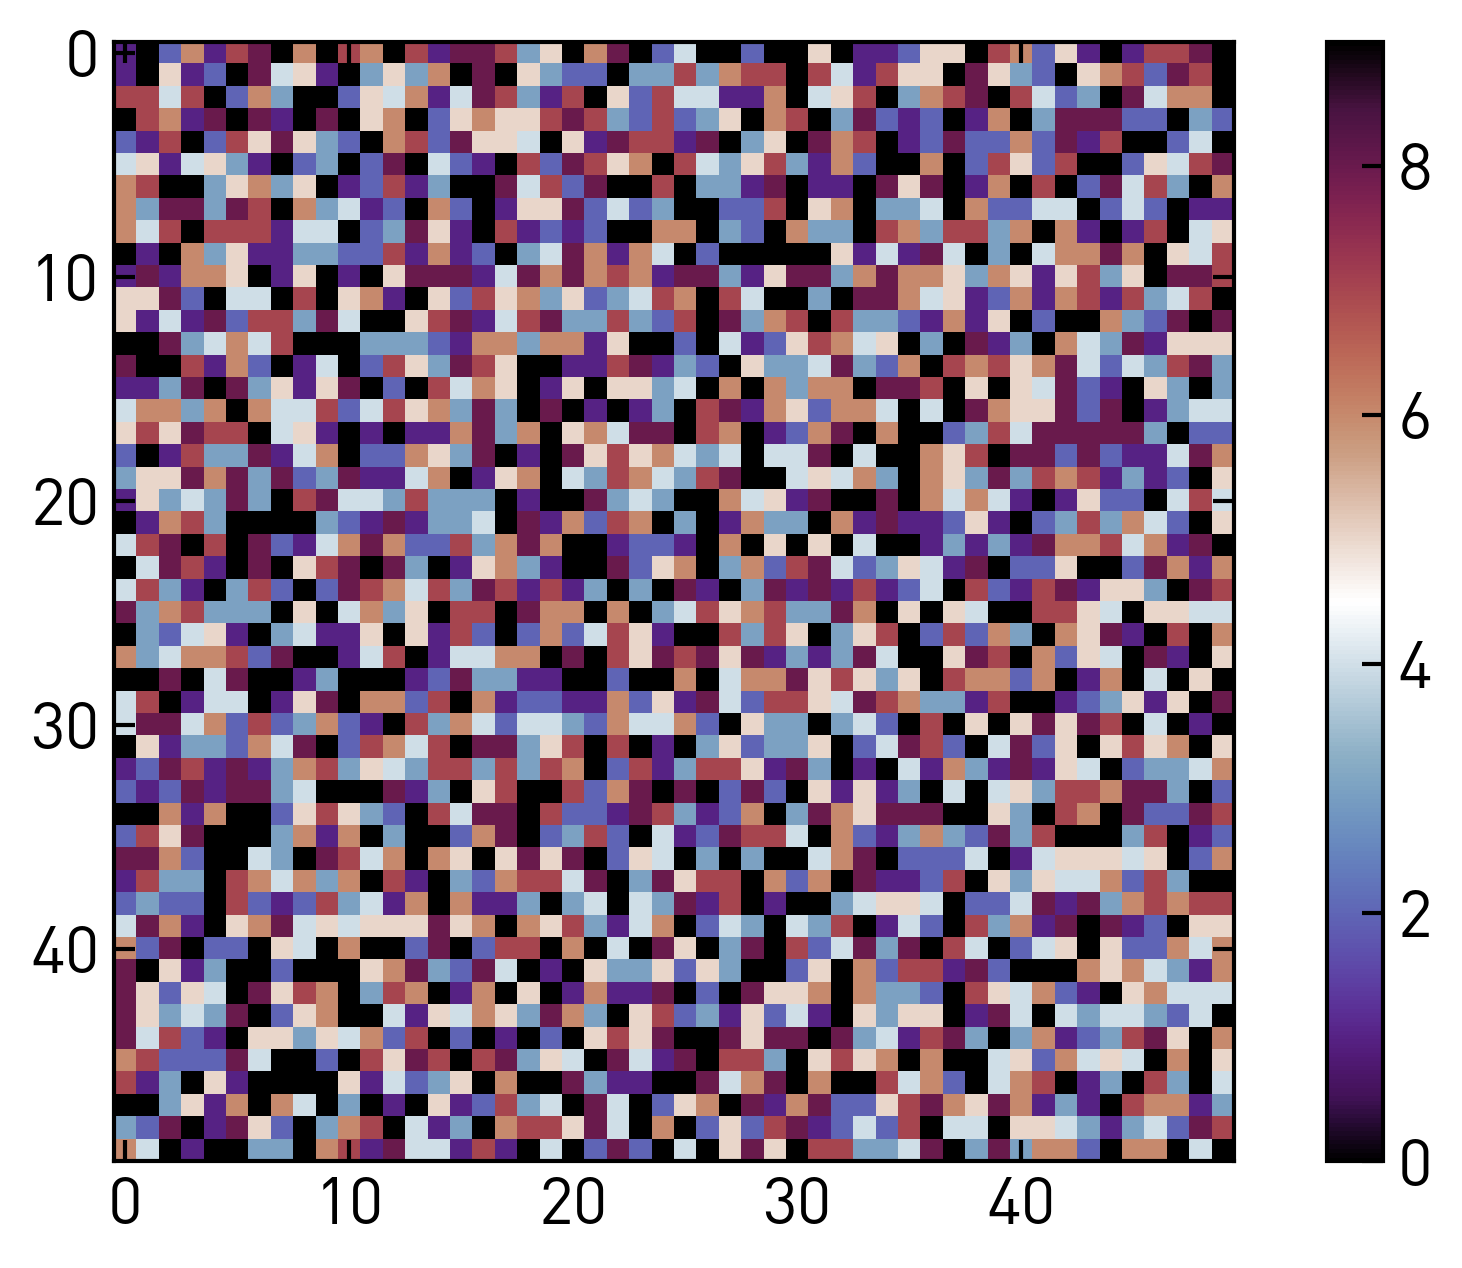

In [183]:
plt.imshow(np.random.randint(0, 10, size=(50, 50)), cmap=cmap_phase)
plt.colorbar(cmap=cmap_phase)

# Theory

In [6]:
# obtained from mathematica notebook
def pop11(t, delta=0, J=1):
    return (2*J**2 + delta**2 + 2*J**2* np.cos(2*np.pi*t*np.sqrt(4 *J**2 + delta**2)))/(4*J**2 + delta**2)
def phase11(t, delta=0, J=1):
    val = (np.exp(-(1/2)*1j*2*pi *t* delta)) *(np.cos(1/2*2*pi* t* np.sqrt(4 *J**2 + delta**2)) + (1j *delta* np.sin(2*pi*1/2 *t * np.sqrt(4* J**2 + delta**2)))/ np.sqrt(4*J**2 + delta**2))

    return np.arctan2(np.imag(val), np.real(val))
#     return np.arctan2(np.sqrt(4*J**2 + delta**2) *np.sin(t* np.sqrttah(4*J**2 + delta**2)), (-delta + delta* np.cos(t *np.sqrt(4 *J**2+ delta**2))))
#     return np.arctan2(delta*np.sin(2*np.pi*t/2*np.sqrt(4 *J**2 + delta**2))/(np.sqrt(4 *J**2 + delta**2)), np.cos(2*np.pi*t/2*np.sqrt(4 *J**2 + delta**2)))
#     return np.arctan((delta* np.tan(2*np.pi*1/2 *t*np.sqrt(4* J**2 + delta**2)))/(np.sqrt(4* J**2 + delta**2)))

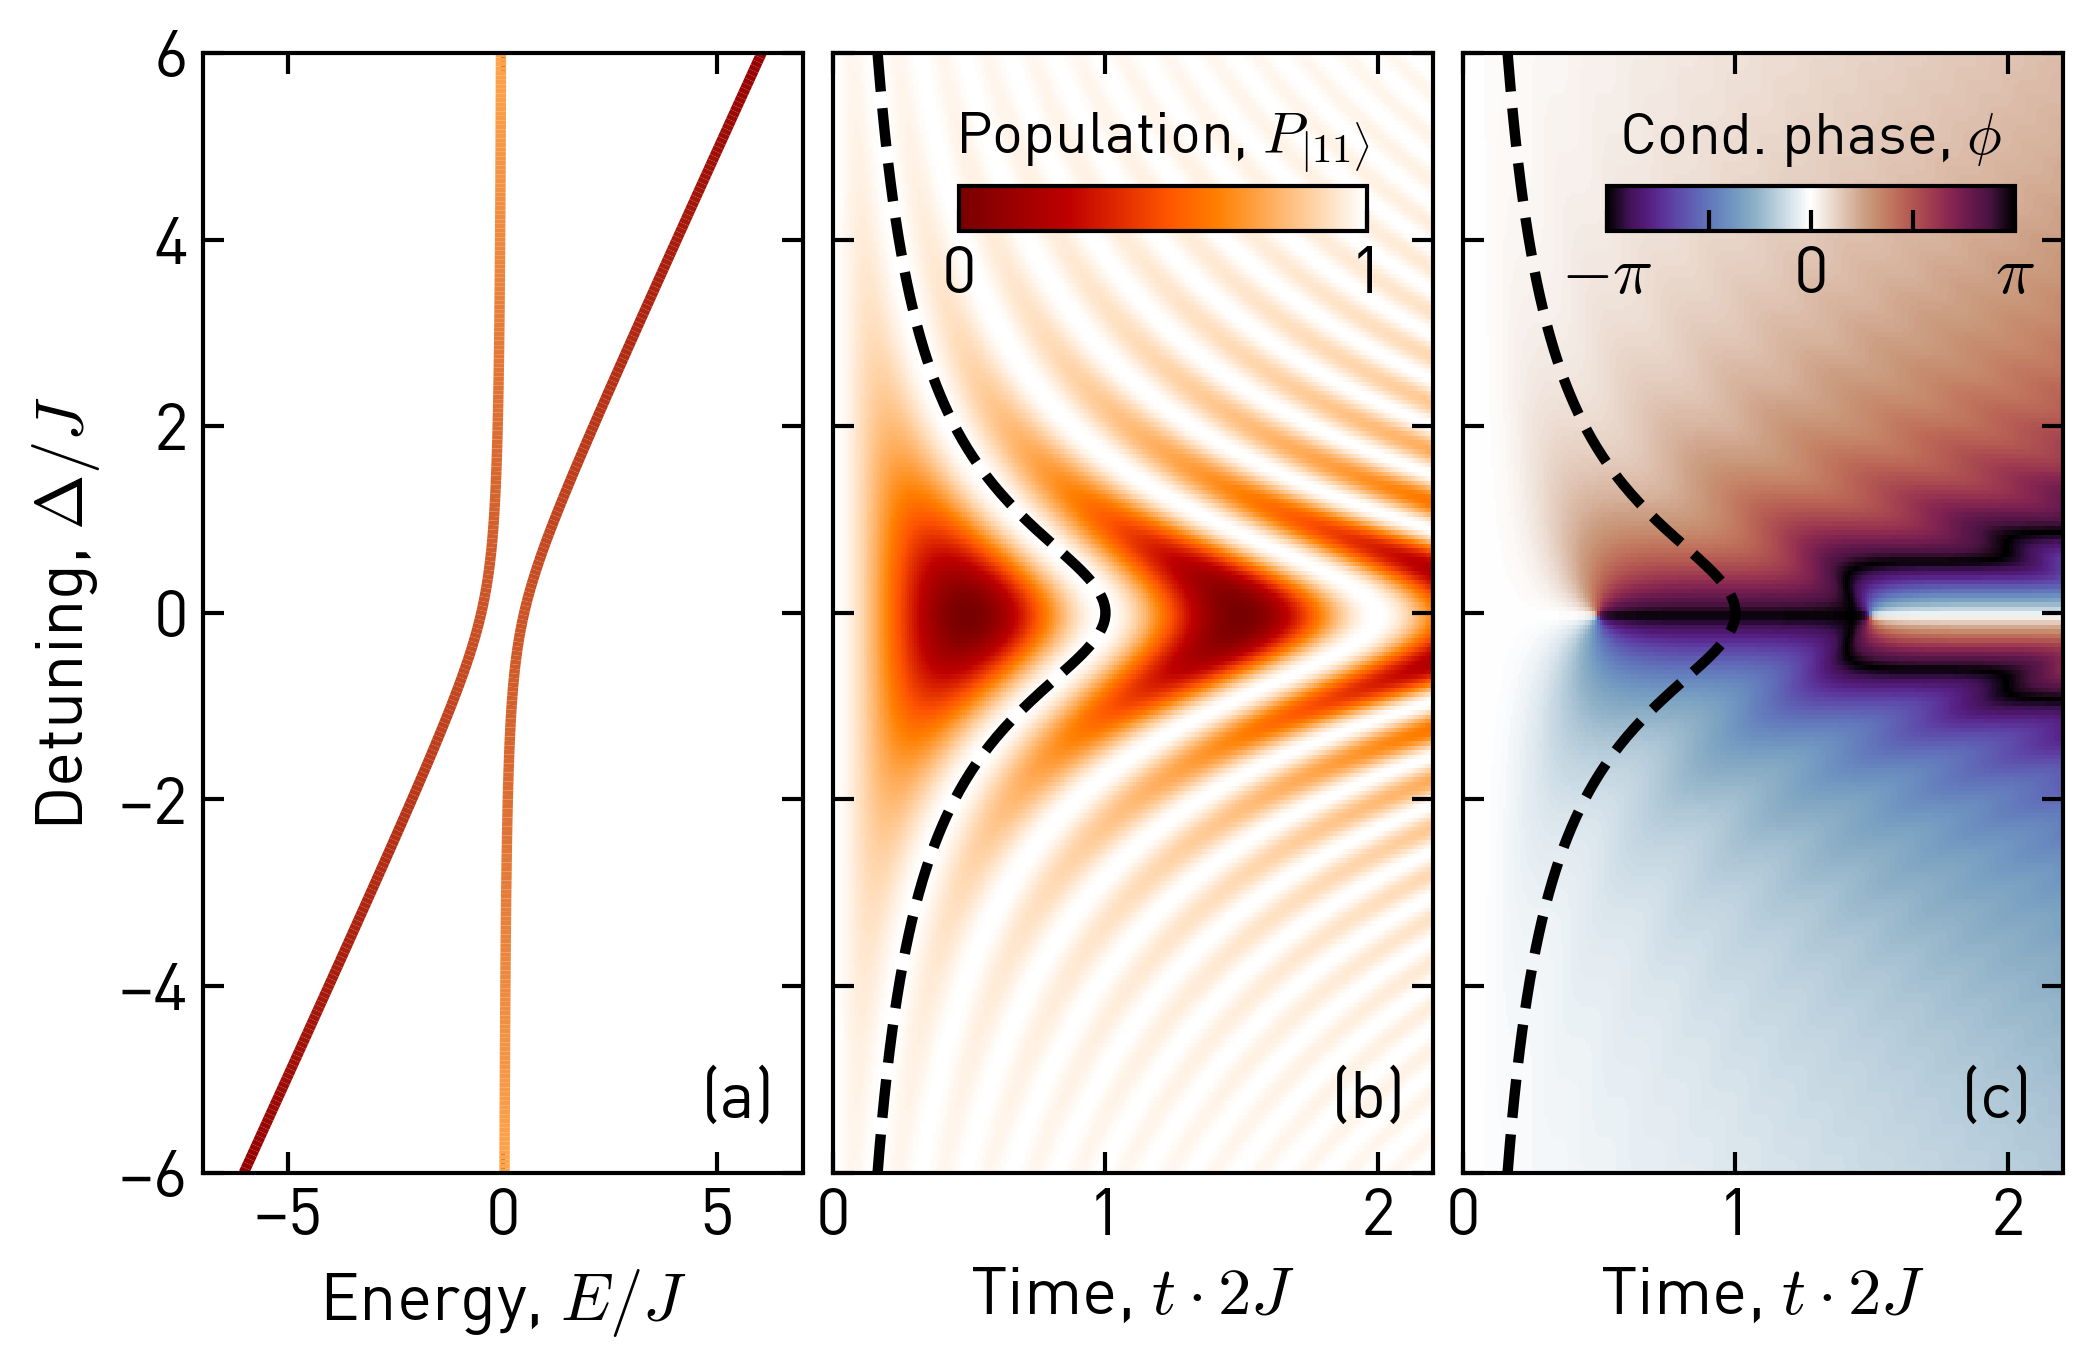

In [184]:
J = 1/2 #np.sqrt(2)*3.3
t = np.linspace(0,2.2,250)*2*J
deltas = np.linspace(-3,3,250)/J

fig, ax = plt.subplots(ncols=3, figsize=(8,fig_size[1]), sharey=True)
tt, dd = np.meshgrid(t, deltas)
pop = pop11(tt, dd, J)
phase = phase11(tt, dd, J)

# chevron
cmap_chevron = cmap #plt.get_cmap('gist_heat') #plt.get_cmap('OrRd').reversed()
im = plot_colormesh(tt, dd, pop, ax[1], cmap=cmap_chevron, colorbar=False, vmin=0, vmax=1, labels=False)
ax[1].set_xlabel('Time, $t\cdot 2J$')
cbaxes = fig.add_axes([0.44, 0.76, 0.17, 0.03]) 
cb = plt.colorbar(ax[1].collections[0], ax=ax[1], cax=cbaxes, orientation="horizontal", ticks=[0,1])
cb.set_label(r'Population, $P_{|11\rangle}$',fontsize=14)
cbaxes.xaxis.set_ticks_position('bottom')
cbaxes.xaxis.set_label_position('top')
cb.set_label(r'Population, $P_{|11\rangle}$', labelpad=8)

# ax[1].plot(0.5*deltas -0.5*np.sqrt(4*J**2+deltas**2), deltas)
# ax[1].plot(0.5*deltas +0.5*np.sqrt(4*J**2+deltas**2), deltas)
# deltas_selection = [-5,-2,-1,0]
# for i, delta in enumerate(deltas_selection):
#     ax.plot(t, pop11(t, delta, J), color=selection_color[i])

# eigenvalues
c = mcolors.ColorConverter().to_rgb
cmap_eig = make_colormap( [plt.get_cmap('gist_heat')(100)[:3],plt.get_cmap('gist_heat')(210)[:3]])
y, x= deltas, 0.5*deltas -0.5*np.sqrt(4*J**2+deltas**2)
gradient_collection(x,y, ax[0], cmap=cmap_eig)
y, x= deltas, 0.5*deltas +0.5*np.sqrt(4*J**2+deltas**2)
gradient_collection(x,y, ax[0], True, cmap=cmap_eig)
ax[0].set_xlim([-7, 7])
ax[0].set_xlabel('Energy, $E/J$')
ax[0].set_ylabel(r'Detuning, $\Delta/J$')

# phase
p = plot_colormesh(tt, dd, phase, ax[2], cmap=cmap_phase, colorbar=False, vmin=-np.pi, vmax=np.pi, labels=False, alpha=1)
cbaxes2 = fig.add_axes([0.71, 0.76, 0.17, 0.03]) 
cb2 = plt.colorbar(ax[2].collections[0], ax=ax[2], cax=cbaxes2, orientation="horizontal", ticks=[-pi, -pi/2,0,pi/2, pi])
cb2.set_label(r'Cond. phase, $\phi$',fontsize=14)
cbaxes2.xaxis.set_label_position('top')
cb2.ax.set_xticklabels([r'$-\pi$', r' ','0',r' ',r'$\pi$'])
cb2.set_label(r'Cond. phase, $\phi$', labelpad=8)
ax[2].set_xlabel('Time, $t\cdot 2J$')


# recoverly line
times_first_osc = 2*pi/np.sqrt((2*pi*deltas)**2+4*(2*pi*J)**2)
ax[1].plot(times_first_osc, deltas,'k--' )
ax[2].plot(times_first_osc, deltas,'k--' )

# config
for a,l in zip(ax, ['(a)', '(b)', '(c)']):
    a.text(0.83,0.05,l, transform=a.transAxes)
plt.subplots_adjust(wspace=0.05)
# ax[1].set_ylim([-3, 3])

In [185]:
fig.savefig(figsave_base+"ch4_carb_theory_c3_{:%Y%m%d_%H%M%S}.png".format(datetime.now()))

# Calibration

In [19]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [20]:
timestamp = "20191208_172019"
for qb in qubits:
    gen.load_settings(qb, timestamp=timestamp)
clear_output()

## Conditional Phase

In [21]:
# load data from measurement
# timestamp = "20191208_151620"
# channel_map = {'qb2': ['UHF_pg w23 UHF', 'UHF_pe w23 UHF', 'UHF_pf w23 UHF'],
#                'qb3': ['UHF_pg w45 UHF', 'UHF_pe w45 UHF', 'UHF_pf w45 UHF']} 
# c_a = tda.CPhaseLeakageAnalysis(t_start=timestamp,
#             qb_names=['qb3', 'qb2'],
#             options_dict={'TwoD': True, 'plot_all_traces': True, "leakage_qbname": 'qb2',
#                           'plot_all_probs': True, 'channel_map': channel_map }, auto=True)

# cphases = c_a.proc_data_dict['analysis_params_dict']['cphase']['val']
# cphases_std = c_a.proc_data_dict['analysis_params_dict']['cphase']['stderr']
# pop_loss = c_a.proc_data_dict['analysis_params_dict']['population_loss']['val']
# pop_loss_std = c_a.proc_data_dict['analysis_params_dict']['population_loss']['stderr']
# amplitudes = c_a.raw_data_dict['exp_metadata']['soft_sweep_params']['amplitude']['values']
# amplitudes = amplitudes/2 # due to ppV bug in code, final voltage seen by qb is divided by two compared to higher level 

# load data from hdf
timestamp = "20191208_151620"
c_a = ma.MeasurementAnalysis(timestamp=timestamp, auto=False)
cphases = np.array(c_a.data_file['Analysis']['Processed data']['analysis_params_dict']['cphase']['val'])
cphases_std =  np.array(c_a.data_file['Analysis']['Processed data']['analysis_params_dict']['cphase']['stderr'])
pop_loss =  np.array(c_a.data_file['Analysis']['Processed data']['analysis_params_dict']['population_loss']['val'])
pop_loss_std =  np.array(c_a.data_file['Analysis']['Processed data']['analysis_params_dict']['population_loss']['stderr'])
amplitudes = np.array(c_a.data_file['Experimental Data']['Experimental Metadata']['soft_sweep_params']['amplitude']['values'])
amplitudes = amplitudes/2 # due to ppV bug in code, final voltage seen by qb is divided by two compared to higher level 
soft_sweep_params = c_a.data_file['Experimental Data']['Experimental Metadata']['soft_sweep_params']
soft_sweep_params = {k: {kk: np.array(vv) for kk, vv in v.items()} for k, v in soft_sweep_params.items()}
hard_sweep_params = c_a.data_file['Experimental Data']['Experimental Metadata']['hard_sweep_params']
hard_sweep_params = {k: {kk: np.array(vv) for kk, vv in v.items()} for k, v in hard_sweep_params.items()}


In [22]:
# prepare plot
cphases = np.unwrap(cphases)
highlighted_selection = [find_nearest(cphases,v) for v in [np.pi/4, np.pi/2, np.pi]]
cmap = plt.get_cmap('winter')
selection_color = [cmap(i) for i in np.linspace(0,1, len(highlighted_selection))]


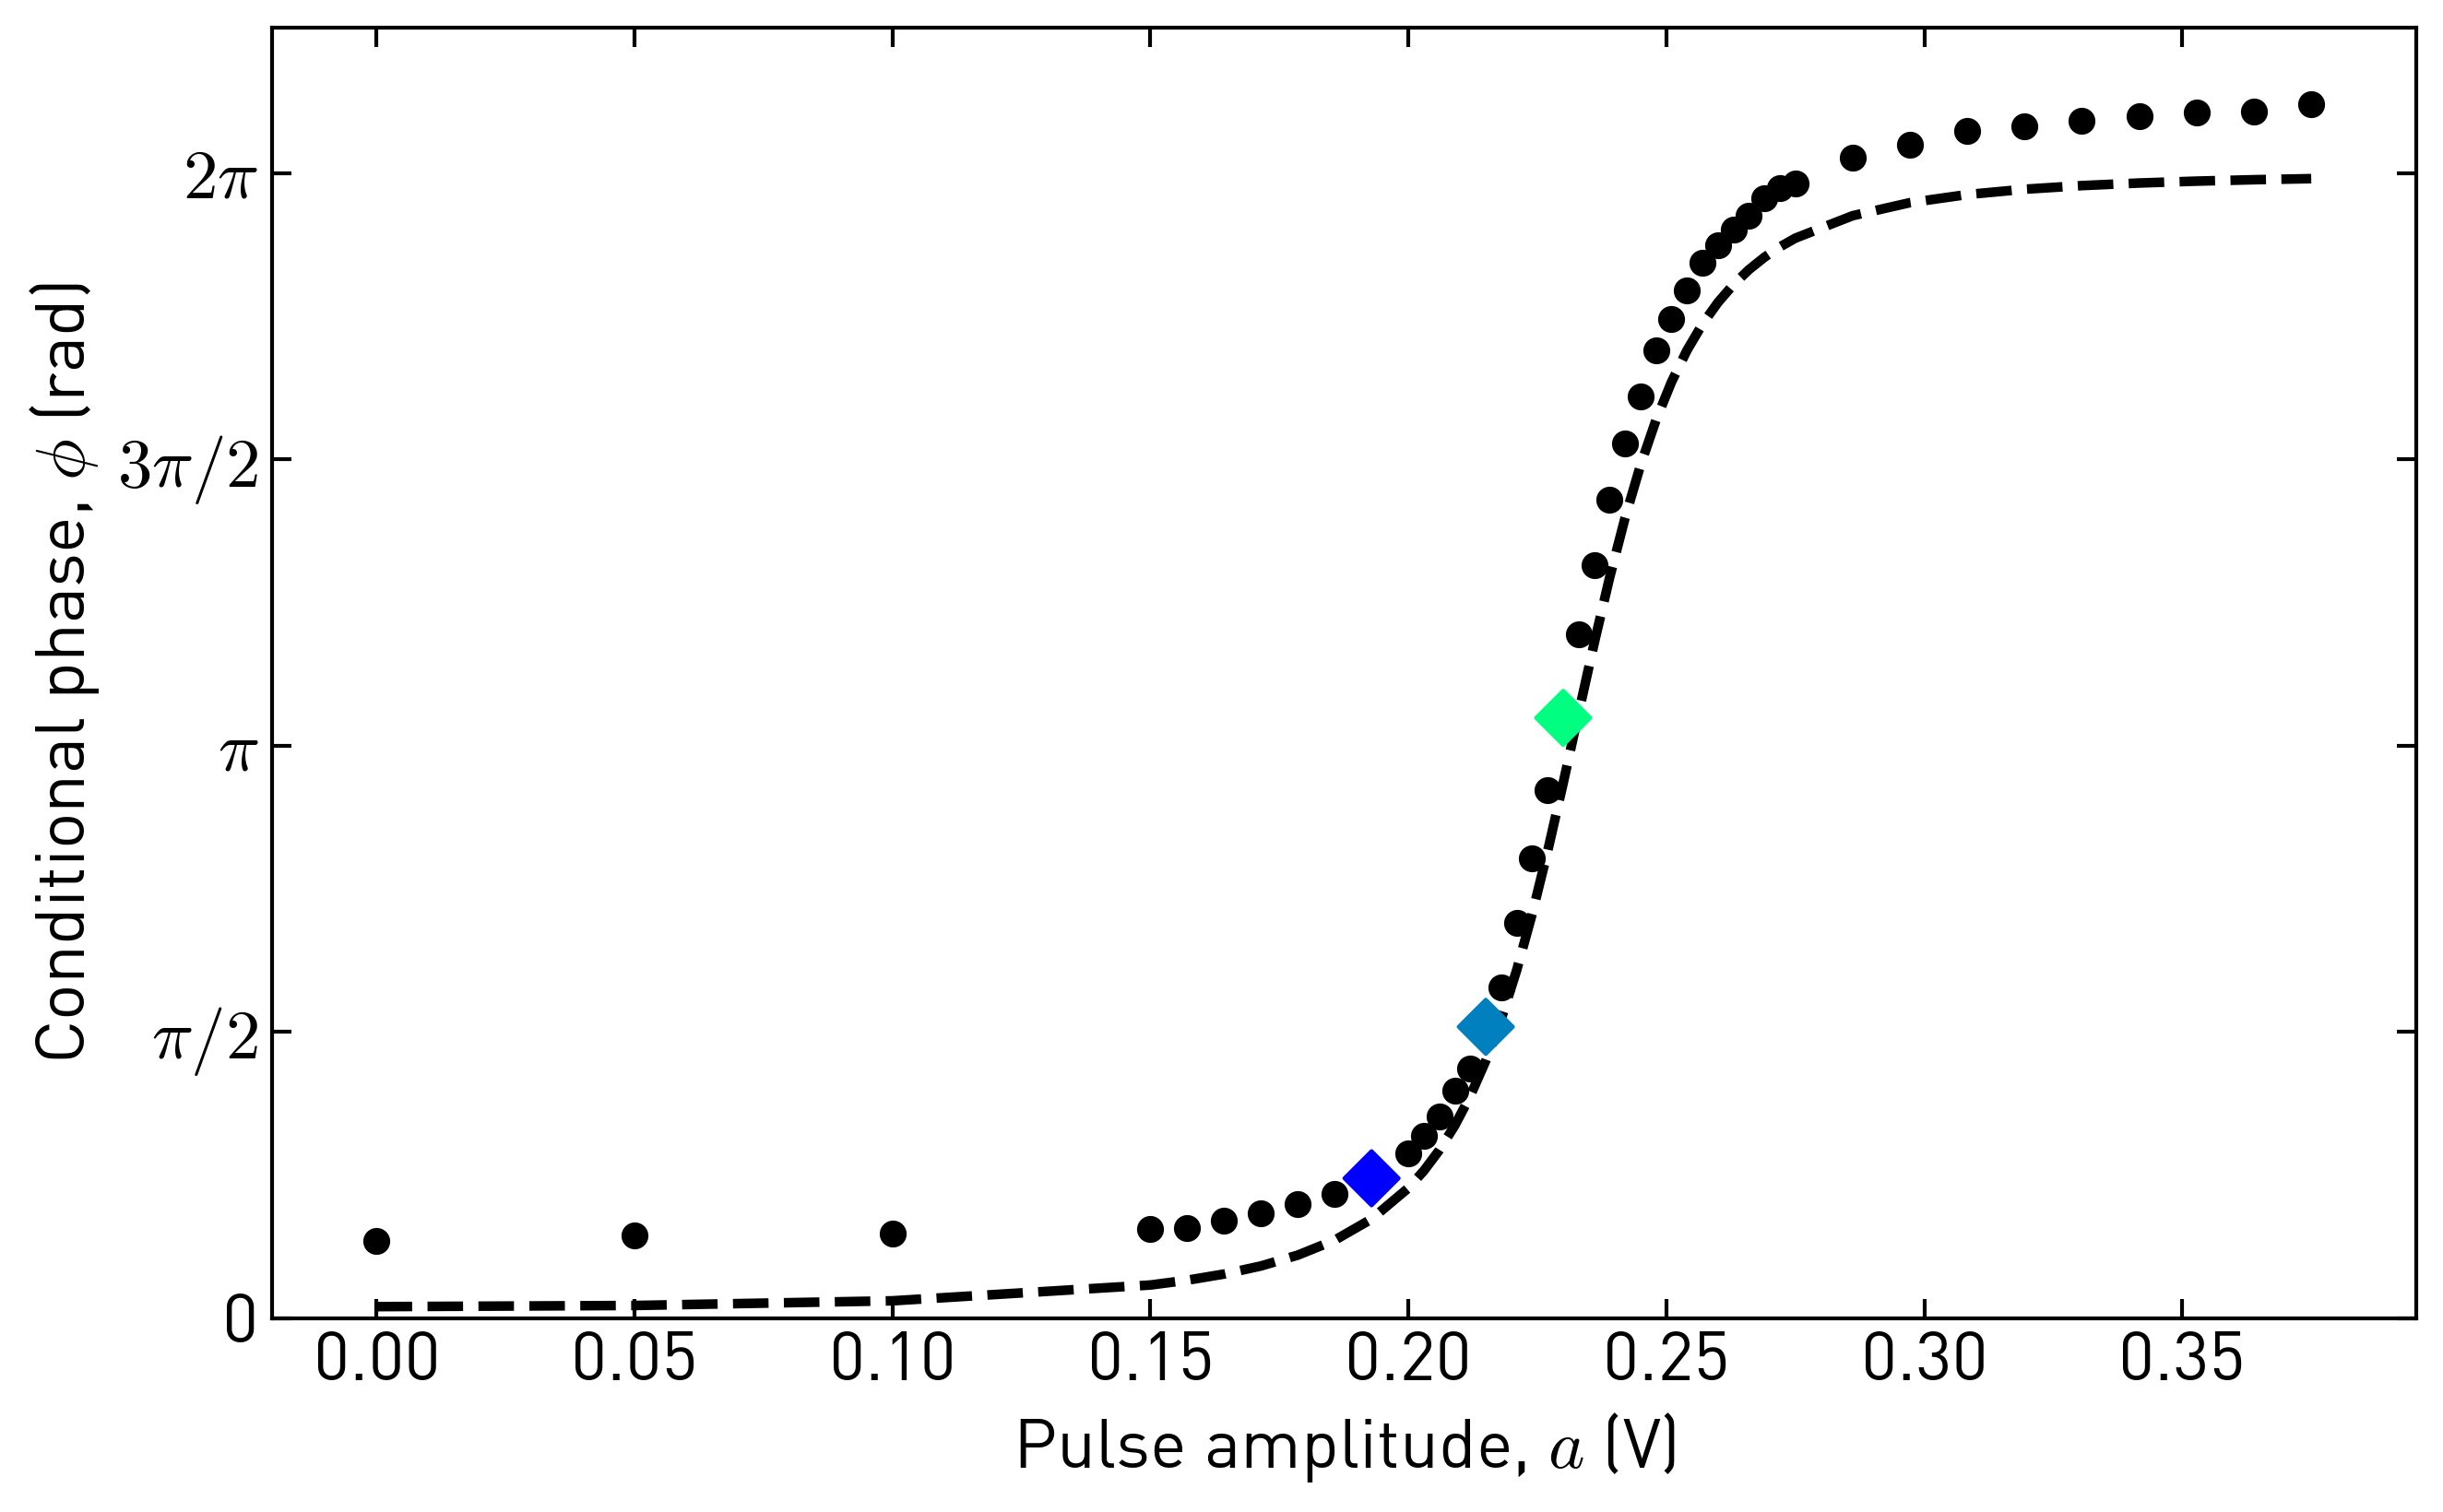

In [95]:
# plot conditional phase
fig, ax = plt.subplots()
ax.scatter(amplitudes, cphases*radians, xunits=radians, c='k', marker='o') #, c=[cmap((i % (2*np.pi))/(2*np.pi)) for i in cphases])
ax.scatter(amplitudes[highlighted_selection], cphases[highlighted_selection]*radians, 
           c=selection_color, s=100, marker='D')
# ax.axhline(0*radians, xunits=radians, linestyle='--', color='grey')
# ax.axhline(2*np.pi*radians, xunits=radians,linestyle='--', color='grey')
ax.set_xlabel("Pulse amplitude, $a$ (V)")
ax.set_ylabel("Conditional phase, $\phi$ (rad)")
ax.set_ylim([0, 2*np.pi + 0.8])

# ax.scatter(amplitudes, -0.06323235/3.017122067218969e-08*(np.amax(times) - times) + cphases)
#fit
try:
    J_00_10 = m.best_values['J_00_10'] # in Hz 
    d = m.best_values['d']
    dphi_dv = m.best_values['dphi_dv']
    cphases_model = calc_cphase(amplitudes,
            qbc_freq_sweetspot=5.5315e+09, #qbc_freq_sweetspot, #5.53247417e+09, 
            qbc_anharmonicity= qbc.anharmonicity(), #qbc_anharmonicity, 
            qbt_ge_freq=qbt.ge_freq(),
            qbt_anharmonicity=qbt.anharmonicity(), #qbt_anharmonicity, 
           dphi_dv=dphi_dv, 
           J_00_10=J_00_10, junction_asym=d,
            ej_correction_factor=1,
           flux_upwards=True)
    ax.plot(amplitudes, (2*np.pi - cphases_model)*radians, xunits=radians, linestyle='--', zorder=-1, color='k')
except:
    pass
# plt.ylim([0, 2* np.pi])

In [97]:
cphases[0]

0.42397055478248113

In [240]:
# explained by alpha_zz
residual_zz = 400e3
time_to_collect_phase = (107+25)*1e-9 # gate time + buffers 
res_zz_phase = residual_zz*2*np.pi*time_to_collect_phase
res_zz_phase + (2*np.pi - cphases_model[0])

0.3951656109948406

In [91]:
0.06323235/3.017122067218969e-08*(np.amax(times) - times)

array([0.16068991, 0.16068991, 0.16068991, 0.16068991, 0.15119581,
       0.14796874, 0.13782674, 0.12949253, 0.11670405, 0.10414051,
       0.08667322, 0.07730906, 0.06721459, 0.05759351, 0.05044918,
       0.03870922, 0.02763951, 0.01417599, 0.00505277, 0.00120921,
       0.        , 0.00142229, 0.00658004, 0.01459373, 0.02398533,
       0.03448182, 0.04546015, 0.05632179, 0.06624006, 0.07569702,
       0.08446633, 0.09253018, 0.09958859, 0.10616274, 0.11235677,
       0.11804734, 0.13519096, 0.147735  , 0.15775215, 0.16477635,
       0.17137974, 0.17662154, 0.18117283, 0.18493013, 0.18715391])

In [85]:
2*pi - calc_cphase(amplitudes,
        qbc_freq_sweetspot=5.5315e+09, #qbc_freq_sweetspot, #5.53247417e+09, 
        qbc_anharmonicity= qbc.anharmonicity(), #qbc_anharmonicity, 
        qbt_ge_freq=qbt.ge_freq(),
        qbt_anharmonicity=qbt.anharmonicity(), #qbt_anharmonicity, 
       dphi_dv=dphi_dv, junction_asym=asym,
       J_00_10=J_00_10, #3.4e6, 
        ej_correction_factor=1,
       flux_upwards=True)

array([0.06323235, 0.06957313, 0.09525186, 0.18195959, 0.20832899,
       0.24218082, 0.2865295 , 0.34600625, 0.42793227, 0.54419591,
       0.71446542, 0.80928994, 0.92241457, 1.05773685, 1.21970805,
       1.41309216, 1.64241699, 1.91099323, 2.21948145, 2.56426988,
       2.9363466 , 3.32159279, 3.70300355, 4.06421902, 4.39279088,
       4.68179628, 4.92955165, 5.13816673, 5.31186828, 5.45566227,
       5.57448925, 5.67279501, 5.75437487, 5.82236968, 5.87933203,
       5.92731604, 6.05065172, 6.12233867, 6.16682479, 6.19595839,
       6.21589434, 6.23003731, 6.2403756 , 6.24812539, 6.25406051])

### pulse scheme


In [67]:
## Sequence
from pycqed.measurement.pulse_sequences import fluxing_sequences as fsqs
reload(segm)

qbc = qb3
qbt = qb2
cz_pulse_name = f"upCZ {qbt.name} {qbc.name}"
operation_dict = mqm.get_operation_dict([qbt, qbc])
sequences, hard_sweep_points, soft_sweep_points = \
        fsqs.cphase_seqs(
            hard_sweep_dict=hard_sweep_params,
            soft_sweep_dict=soft_sweep_params,
            qbc_name=qbc.name, qbt_name=qbt.name,
            cz_pulse_name=cz_pulse_name,
            operation_dict=operation_dict,
            cal_points=c_p.CalibrationPoints([], []), upload=False)

max_pulse_length = 107.00 ns, from pulse dict.


In [241]:
%matplotlib inline

(-0.35, 0.35)

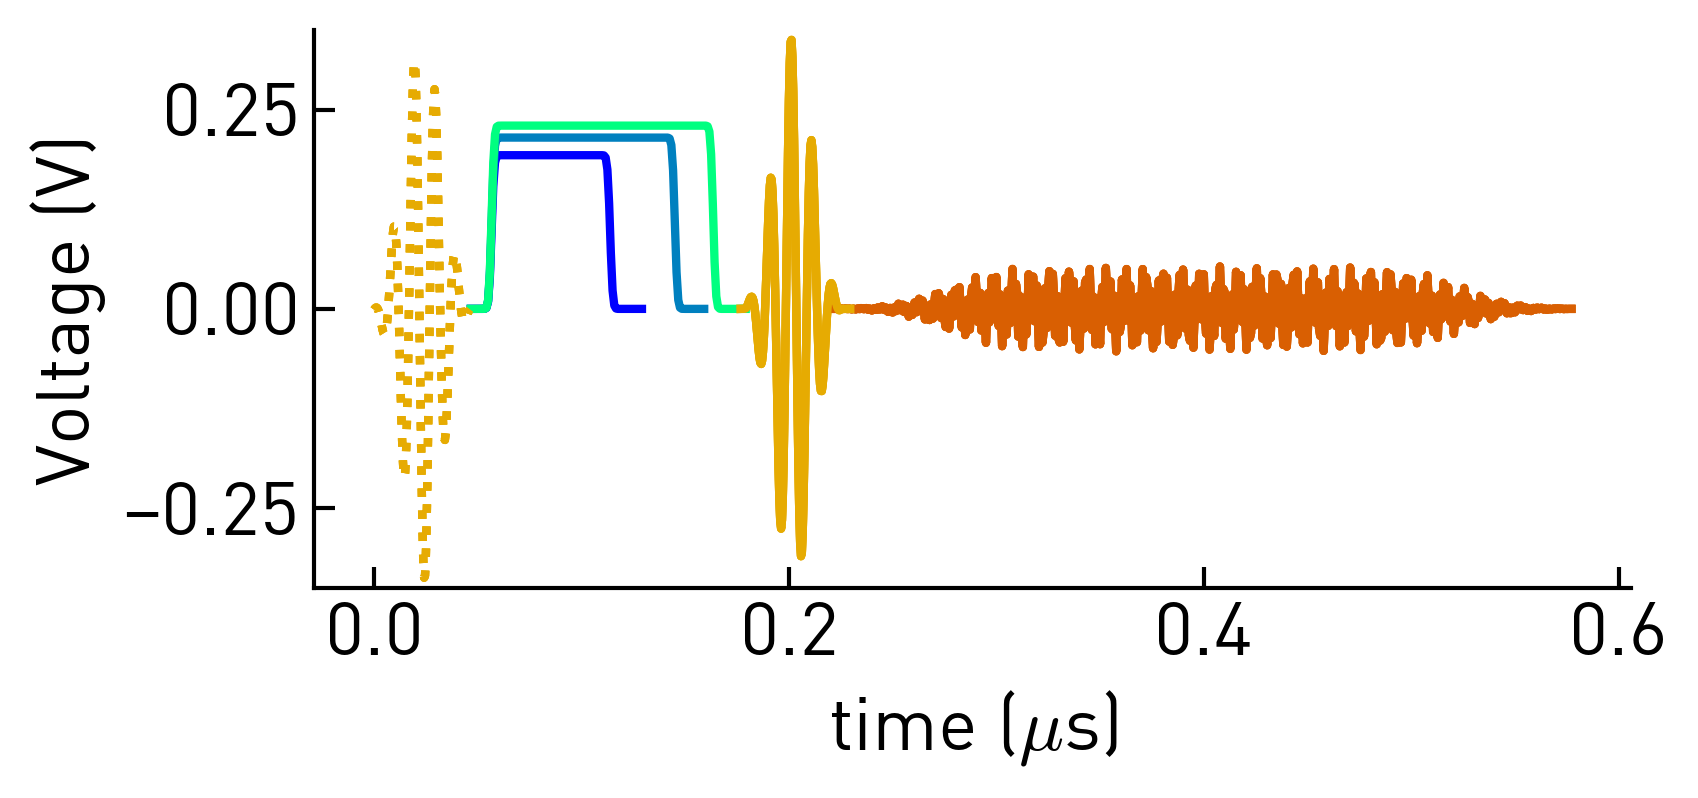

In [78]:
# plot pulse scheme for selection qb3
# %matplotlib notebook
cmap = plt.get_cmap('Dark2')
qb_map = dict(#qb2=['AWG8_ch3', "UHF_ch1"], 
              qb3=['AWG8_ch5', "UHF_ch1", "AWG2_ch1"])
plot_kwargs=dict(linewidth=2)
fig, ax = plt.subplots(nrows=1, squeeze=False, sharex=True, figsize=(6,3))
for i, seq in enumerate(np.array(sequences)[highlighted_selection]):
    seq.segments["segment_0"].plot(axes=ax, channel_map=qb_map, frameon=dict(top=False, right=False), plot_kwargs=plot_kwargs,
            prop_cycle=dict(color=[cmap(0.21),selection_color[i],  cmap(0.7), cmap(0.7)],
                           linestyle=['-','-', 'dotted', '-']), 
                                   legend=False, demodulate=False)
    plt.tick_params(top=False, right=False)
fig.suptitle("")
ax[0,0].set_ylim([-0.35,0.35])
# %matplotlib inline

In [79]:
fig.savefig(figsave_base+"ch4_carb_pulse_scheme_qb3_{:%Y%m%d_%H%M%S}.png".format(datetime.now()))

(-0.35, 0.35)

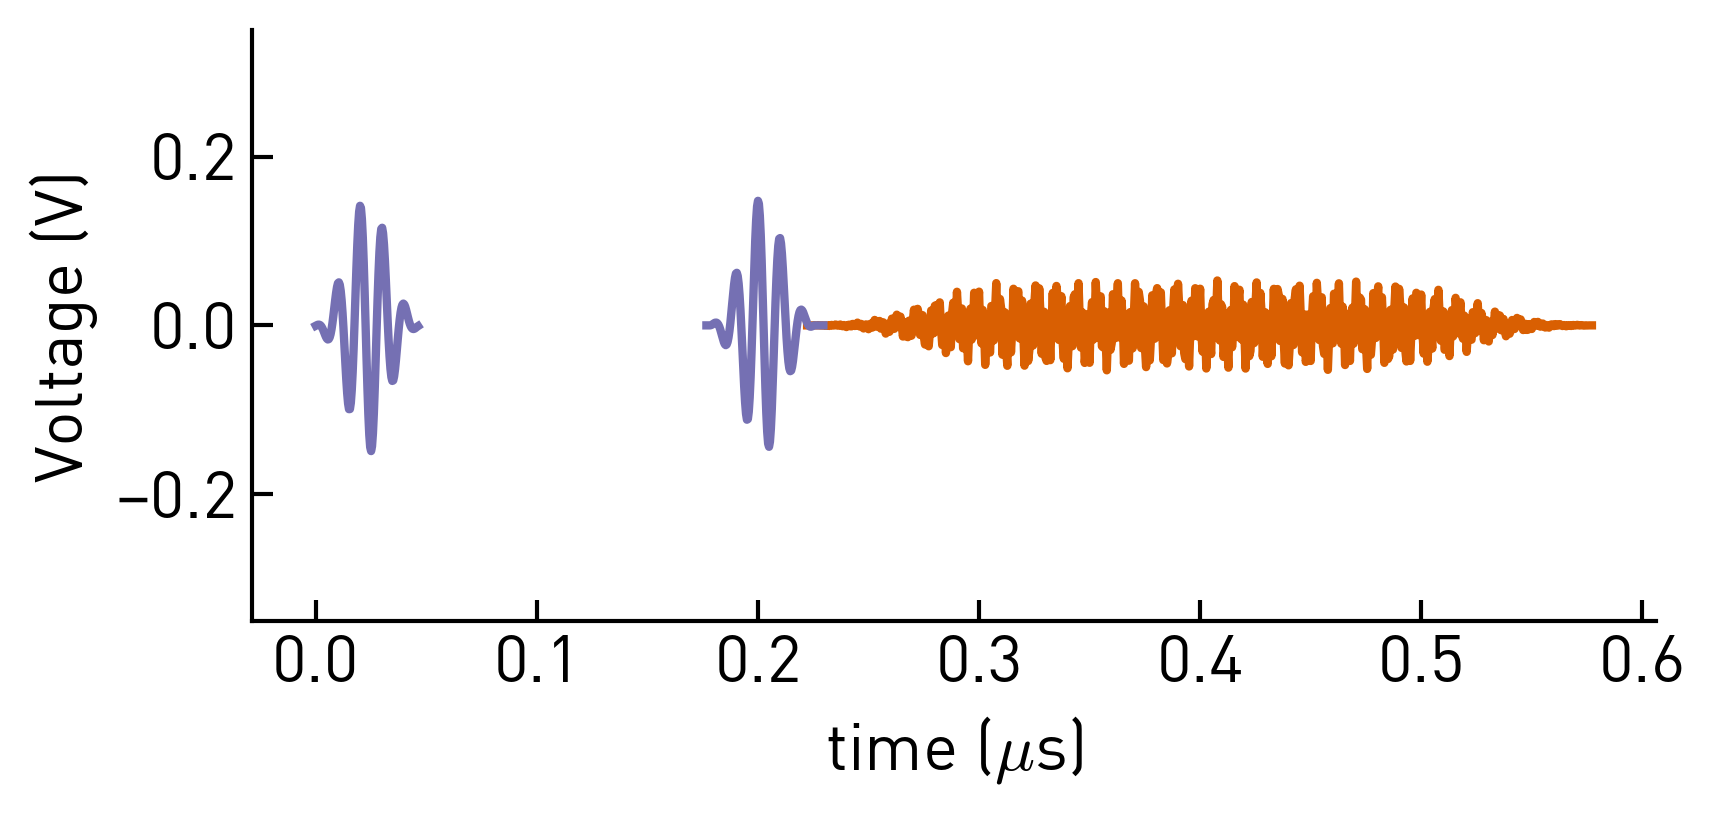

In [105]:
# qb2
qb_map = dict(qb2=['AWG8_ch3', "UHF_ch1"]) 
              #qb3=['AWG8_ch5', "UHF_ch1", "AWG2_ch1"])
plot_kwargs=dict(linewidth=2)
fig, ax = plt.subplots(nrows=1, squeeze=False, sharex=True, figsize=(6,3))
for i, seq in enumerate(np.array(sequences)[[0]]):
    seq.segments["segment_0"].plot(axes=ax, channel_map=qb_map, frameon=dict(top=False, right=False), plot_kwargs=plot_kwargs,
            prop_cycle=dict(color=[cmap(0.21), cmap(0.3),cmap(0.3)]), legend=False, demodulate=False)
    plt.tick_params(top=False, right=False)
fig.suptitle("")
ax[0,0].set_ylim([-0.35,0.35])


In [106]:
fig.savefig("ch4_carb_pulse_scheme_qb2.png")

## Chevron

In [24]:
#functions
def effective_time(J_11_20, delta_20_11, n=1, time=None):
    if time is None:
        time = n / (2 * J_11_20)
    return 2 * np.pi * 2 * J_11_20 * time / np.sqrt(4 * (2*np.pi*J_11_20)**2 + (2*np.pi*delta_20_11)**2) 

def calc_delta_20_11(ge_freq_qbt, ge_freq_qbc, anharmonicity_qbt):
    return ge_freq_qbt - anharmonicity_qbt - ge_freq_qbc

def calc_junction_asym(alpha=1/8):
    return (1 - alpha) / (1 + alpha)

def calc_ge_freq(voltage, dphi_dv, junction_asym, Ec, Ej_max, ej_correction_factor, flux_upwards=False):
    # correction factor is to correct for approximation in formula
    Ej = calc_Ej_from_voltage(voltage, dphi_dv, junction_asym, Ej_max, flux_upwards=flux_upwards)
    return ej_correction_factor * np.sqrt(8 * Ec * Ej) - Ec

def calc_Ej_from_voltage(voltage, dphi_dv, junction_asym, Ej_max, flux_upwards=False):
    offset = 0
    if flux_upwards:
        offset = np.pi/2
    return Ej_max * np.sqrt(np.cos(dphi_dv * voltage+offset)**2 + junction_asym**2 * np.sin(dphi_dv * voltage+offset)**2)

def calc_Ej_from_ge_freq(ge_freq, Ec):
    return ((ge_freq + Ec)**2 )/ (8 * Ec)

def calc_tau_effective(voltages, qbc_freq_sweetspot, qbc_anharmonicity, 
                       qbt_ge_freq, qbt_anharmonicity, dphi_dv, J_00_10, junction_asym=None, 
                       n=1, time=None, ej_correction_factor=1, flux_upwards=False):
    if junction_asym is None:
        junction_asym = calc_junction_asym()
    Ej_max = calc_Ej_from_ge_freq(qbc_freq_sweetspot, -qbc_anharmonicity)
    ge_freq_qbc = calc_ge_freq(voltage=voltages, dphi_dv=dphi_dv, 
                 junction_asym=junction_asym, Ec=-qbc_anharmonicity, 
                Ej_max=Ej_max, ej_correction_factor=ej_correction_factor, flux_upwards=flux_upwards)
    if flux_upwards:
        delta = calc_delta_20_11(qbt_ge_freq, ge_freq_qbc, -qbt_anharmonicity)
    else:
        delta = calc_delta_20_11(ge_freq_qbc, qbt_ge_freq,  -qbc_anharmonicity)
    return effective_time(np.sqrt(2)*J_00_10, delta, n=n, time=time)

def calc_cphase(voltages, qbc_freq_sweetspot, qbc_anharmonicity, 
                       qbt_ge_freq, qbt_anharmonicity, dphi_dv, J_00_10, junction_asym=None, 
                    ej_correction_factor=1, flux_upwards=False):
    if junction_asym is None:
        junction_asym = calc_junction_asym()
    Ej_max = calc_Ej_from_ge_freq(qbc_freq_sweetspot, -qbc_anharmonicity)
    ge_freq_qbc = calc_ge_freq(voltage=voltages, dphi_dv=dphi_dv, 
                 junction_asym=junction_asym, Ec=-qbc_anharmonicity, 
                Ej_max=Ej_max, ej_correction_factor=ej_correction_factor, flux_upwards=flux_upwards)
    if flux_upwards:
        delta = calc_delta_20_11(qbt_ge_freq, ge_freq_qbc, -qbt_anharmonicity) # f_20 - f_11
    else:
        delta = calc_delta_20_11(ge_freq_qbc, qbt_ge_freq,  -qbc_anharmonicity)
    J_11_20 = np.sqrt(2)*J_00_10
    cph = np.pi * (1 + 2*np.pi*delta / np.sqrt((2*np.pi*delta)**2 + 4*(2*np.pi*J_11_20)**2)) # see Heinsoo p.89
    return cph

In [25]:
# load data


timestamp = '20191207_165100' # two level readout
timestamp = '20191207_221812' # 3 level readout
# for qb in qubits:
#     gen.load_settings(qb, timestamp=timestamp)
# clear_output()
qb_name = "qb2"
qbc = qb3
qbt = qb2
a_chev = tda.MultiQubit_TimeDomain_Analysis(qb_names=[qb_name], 
                                         t_start=timestamp, 
                                         options_dict=dict(TwoD=True))
pulse_lengths = a_chev.proc_data_dict['sweep_points_dict'][qb_name]['sweep_points'][:-4]
pulse_amplitudes = a_chev.proc_data_dict['sweep_points_2D_dict'][qb_name]
hard_sweep_params = a_chev.raw_data_dict['exp_metadata']['hard_sweep_params']
soft_sweep_params = a_chev.raw_data_dict['exp_metadata']['soft_sweep_params']
# 3 level readout
pe = a_chev.proc_data_dict['meas_results_per_qb'][qb_name]['UHF_pe w23'].T[:, :-4]
# 2 level readout
# pe = a.proc_data_dict['projected_data_dict'][qb_name]['pe']

c:\users\nathan\code\quantumsoftware\pycqed_py3\pycqed\measurement\hdf5_data.py:282: H5pyDeprecationWarning:

dataset.value has been deprecated. Use dataset[()] instead.



['UHF_pg w23', 'UHF_pe w23', 'UHF_pf w23']
Q:\USERS\nathan\data\thesis_data\20191207\221812_Chevron_qb3qb2
['UHF_w2', 'UHF_w3', 'UHF_w2', 'UHF_w3', 'UHF_w2', 'UHF_w3']
{'qb2': ['UHF_pg w23', 'UHF_pe w23', 'UHF_pf w23']}


In [58]:
# prepare plot
from numpy import array
times = [eval(qbc.upCZ_qb2_chevron_func())(a, qbc.upCZ_qb2_pulse_length()) for a in amplitudes*2] # chevron func is using the "fake high level ampl" --> x2
ampl_fit_for_plot = np.linspace(amplitudes[0], amplitudes[-1], 300)
# fitting
import lmfit

function = lambda a, \
            J_00_10, \
            dphi_dv, d: \
            calc_tau_effective(voltages=a, 
                               qbc_freq_sweetspot=5.5315e+09, #qbc_freq_sweetspot, #5.53247417e+09, 
                               qbc_anharmonicity= qb3.anharmonicity(), #qbc_anharmonicity, 
                               qbt_ge_freq=qb2.ge_freq(),
                               qbt_anharmonicity=qb2.anharmonicity(), #qbt_anharmonicity, 
                               dphi_dv=dphi_dv, junction_asym=d,
                               J_00_10=J_00_10, #3.4e6, 
                                ej_correction_factor=1, #ej_correction_factor,
                               flux_upwards=True)
m = lmfit.Model(function).fit(a=amplitudes, 
                                        data=times, 
                                        qbc_freq_sweetspot=5.530e+09, 
#                                         qbc_anharmonicity=-277299366.41911316, 
                                        qbt_ge_freq=5202172646.701133, 
#                                         qbt_anharmonicity=-275212404.11875725, 
                                        dphi_dv=1.08, 
                              d = 0.77,
                                        ej_correction_factor=1.00,
                                        J_00_10=3.6e6) 
m
#                            ej_correction_factor=ej_correction_factor),)

In [71]:
m.params['J_00_10']

<Parameter 'J_00_10', value=3338922.7261713627 +/- 3.52e+04, bounds=[-inf:inf]>

In [81]:
print("J = " , m.params['J_00_10'].value *np.sqrt(2), "+- " ,  m.params['J_00_10'].stderr*np.sqrt(2))
print("dphi_dv = ", m.params['dphi_dv']/pi, "+- " ,  m.params['dphi_dv'].stderr)
print("d = ", m.params['d'].value, "+- ", m.params['d'].stderr)

J =  4721949.803067289 +-  49799.55300638134
dphi_dv =  0.3396865555113845 +-  0.00910487918708672
d =  0.7884039167192373 +-  0.0002607252723545977


In [50]:
plt.rcParams['xtick.direction'] ='in'
plt.rcParams['ytick.direction'] ='in'

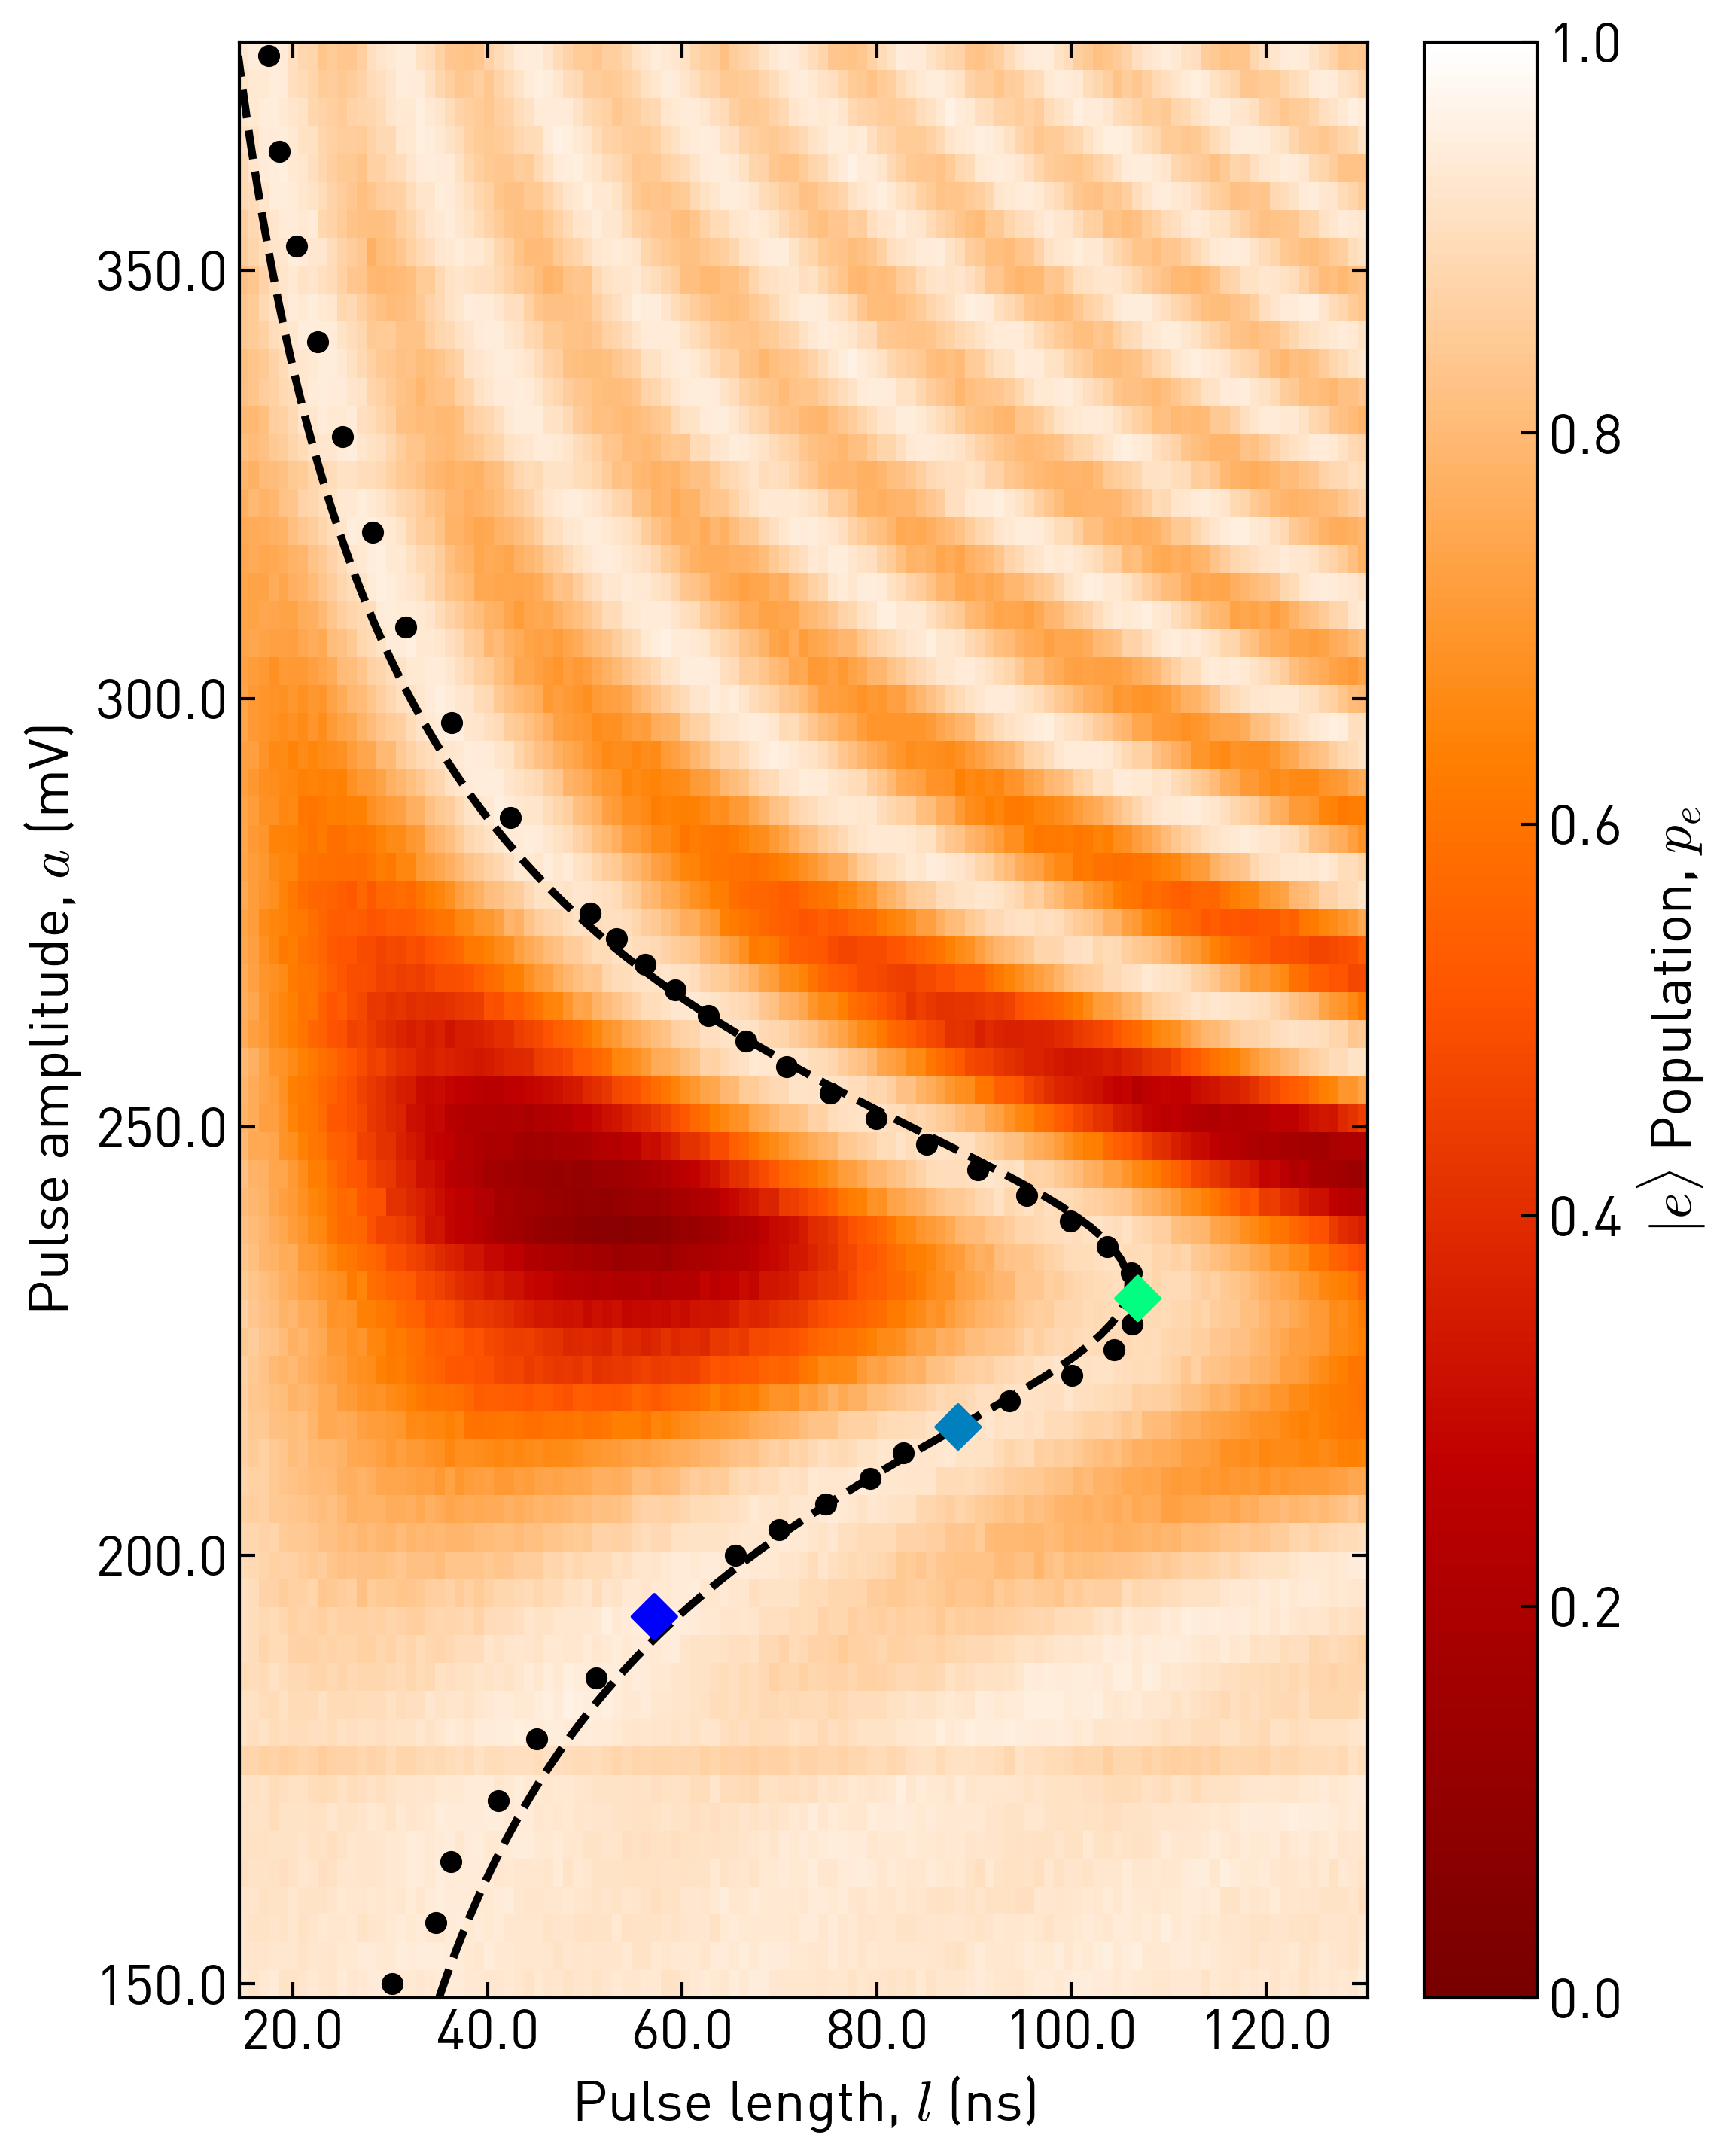

In [59]:
# plot chevron
save= False
fig, ax = plt.subplots(figsize=(8,fig_size_dim/golden_ratio*2))
a_chev.plot_colorxy(dict(xvals=pulse_lengths,
               yvals=pulse_amplitudes/2, # because devides by two due to ppV in code (bug)
                   zvals=pe,
                    
                   xlabel='Pulse length, $l$', 
                    clabel=r'$|e\rangle$ Population, $p_e$',
                    ylabel='Pulse amplitude, $a$', xunit='s', yunit='V', 
                    cmap=cmap_chevron, zrange=[0, 1]), ax)


ax.plot(m.eval(a=ampl_fit_for_plot, **m.best_values), ampl_fit_for_plot, color='k', linestyle='--')

# timing data from cphase measurement
ax.scatter(times, amplitudes, marker="o", c='k',  zorder=3)
ax.scatter(np.array(times)[highlighted_selection], amplitudes[highlighted_selection], marker="D", c=selection_color, 
           s=100, zorder=4)



if save:
    fig.savefig("ch4_chevron.png")
# ax.set_xlim([0, 180e-9])
# ax.set_ylim([amplitudes[0]*0.98 , amplitudes[-1]*1.02 ])

## Pulse Scheme

In [131]:
## Sequence
from pycqed.measurement.pulse_sequences import fluxing_sequences as fsqs
reload(segm)

qbc = qb3
qbt = qb2
qbr = qb2
cz_pulse_name = f"upCZ {qbt.name} {qbc.name}"
operation_dict = mqm.get_operation_dict([qbt, qbc])
sequences, hard_sweep_points, soft_sweep_points = \
        fsqs.chevron_seqs(qbc_name=qbc.name, qbt_name=qbt.name, qbr_name=qbr.name,
            hard_sweep_dict=hard_sweep_params,
            soft_sweep_dict=soft_sweep_params,
            cz_pulse_name=cz_pulse_name,
            operation_dict=operation_dict,
            cal_points=c_p.CalibrationPoints([], []), upload=False)

(-0.35, 0.35)

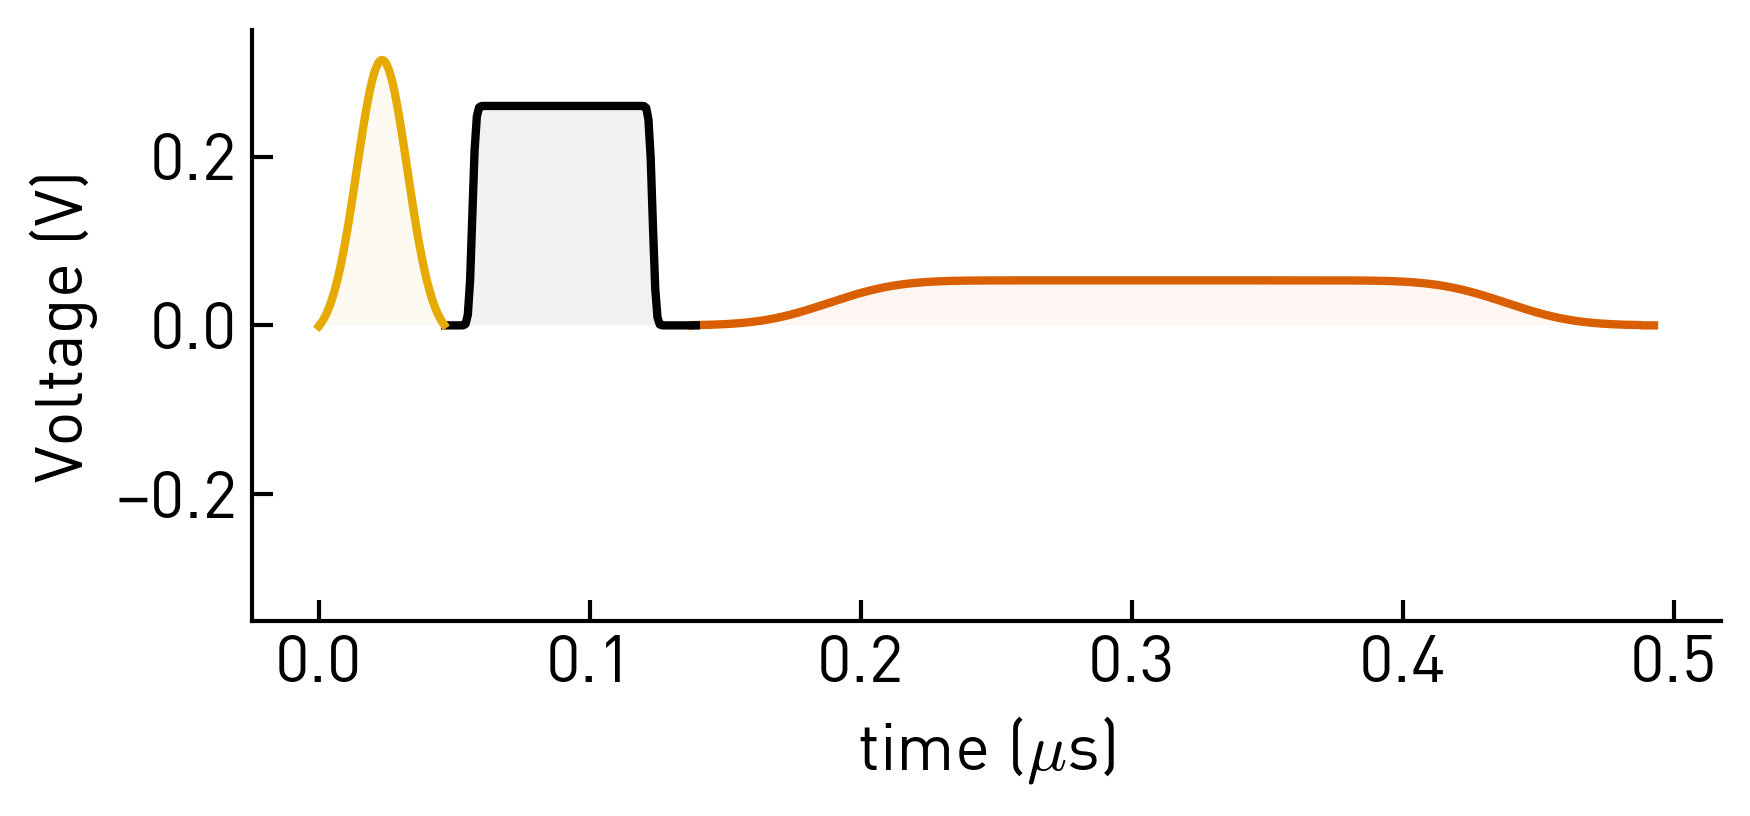

In [133]:
cmap = plt.get_cmap('Dark2')
qb_map = dict(#qb2=['AWG8_ch3', "UHF_ch1"], 
              qb3=['AWG8_ch5', "UHF_ch1", "AWG2_ch1"])
plot_kwargs=dict(linewidth=2)
fig, ax = plt.subplots(nrows=1, squeeze=False, sharex=True, figsize=(6,3))
for i, seq in enumerate(np.array(sequences)[[30]]):
    seq.segments["segment_110"].plot(axes=ax, channel_map=qb_map, frameon=dict(top=False, right=False), plot_kwargs=plot_kwargs,
            prop_cycle=dict(color=[cmap(0.21), 'k', cmap(0.7), cmap(0.21),]), legend=False, demodulate=False)
    plt.tick_params(top=False, right=False)
fig.suptitle("")
ax[0,0].set_ylim([-0.35,0.35])

In [75]:
fig.savefig("ch4_chevron_pulse_scheme_qb3.png")

(-0.35, 0.35)

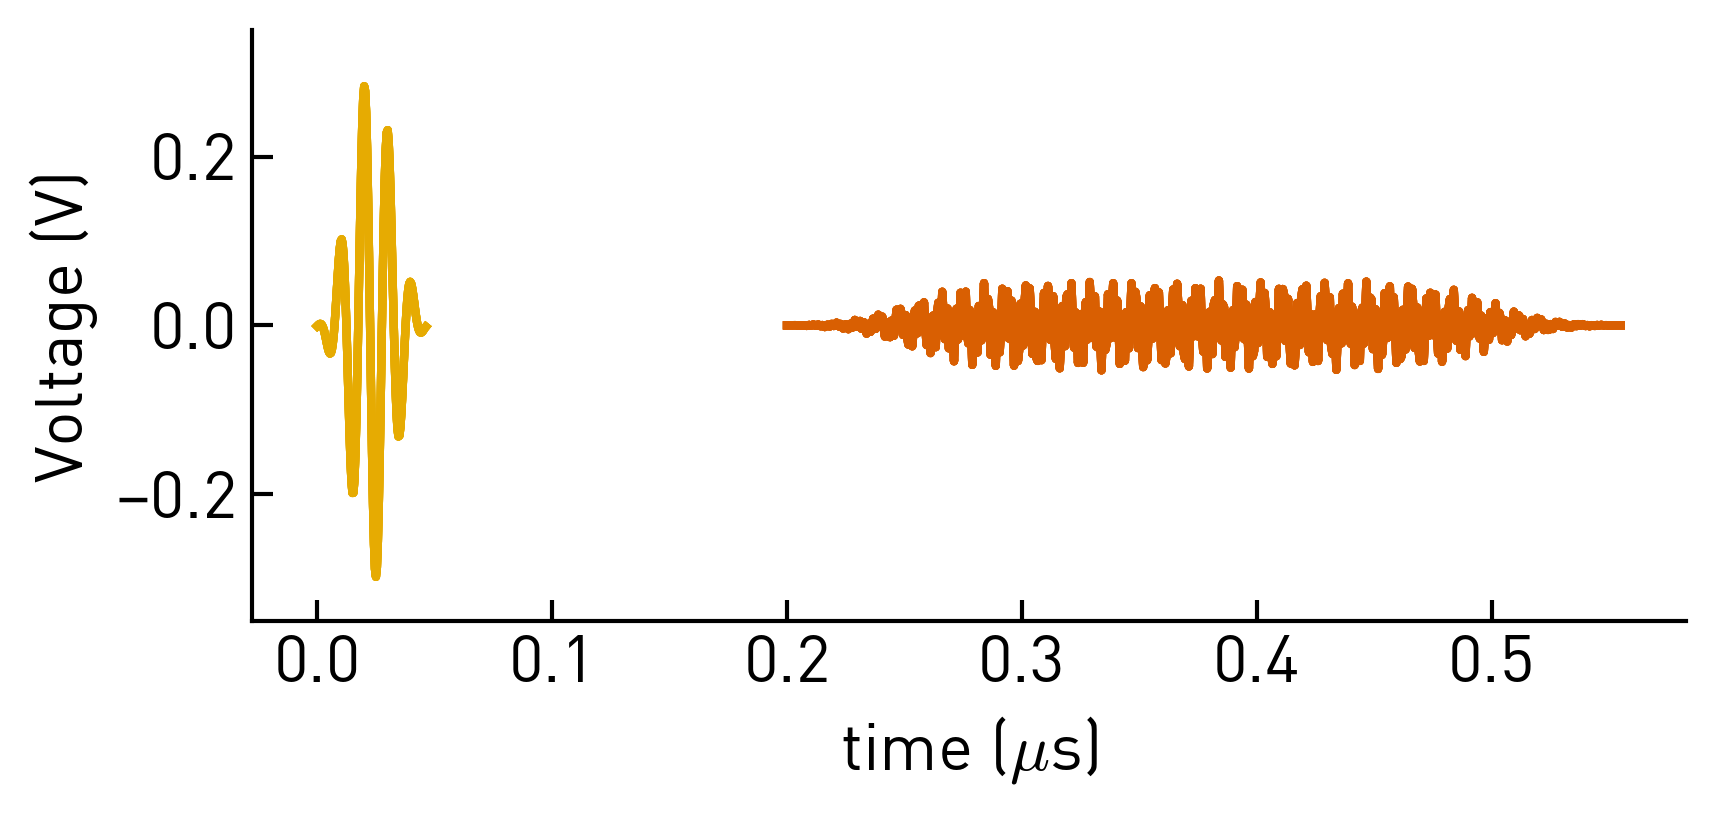

In [76]:
cmap = plt.get_cmap('Dark2')
qb_map = dict(qb2=['AWG8_ch3', "UHF_ch1"]) 
              #qb3=['AWG8_ch5', "UHF_ch1", "AWG2_ch1"])
plot_kwargs=dict(linewidth=2)
fig, ax = plt.subplots(nrows=1, squeeze=False, sharex=True, figsize=(6,3))
for i, seq in enumerate(np.array(sequences)[highlighted_selection]):
    seq.segments["segment_110"].plot(axes=ax, channel_map=qb_map, frameon=dict(top=False, right=False), plot_kwargs=plot_kwargs,
            prop_cycle=dict(color=[cmap(0.2), cmap(0.7),]), legend=False, demodulate=False)
    plt.tick_params(top=False, right=False)
fig.suptitle("")
ax[0,0].set_ylim([-0.35,0.35])

In [77]:
fig.savefig("ch4_chevron_pulse_scheme_qb2.png")

## Dynamic Phase

In [29]:
# load data
timestamp = "20191208_172019"
qbn = "qb3"

a = ma.MeasurementAnalysis(timestamp=timestamp, auto=False)

a.get_naming_and_values()
amplitudes_dyn = np.load(a.folder + "\\amplitudes.npy")/2 #arb_phase_amp_func(np.linspace(0,2*np.pi,45)) #
dph_qbc = np.load(a.folder + f"\\dynamic_phases_{qbn}.npy")

c:\users\nathan\code\quantumsoftware\pycqed_py3\pycqed\analysis\measurement_analysis.py:277: H5pyDeprecationWarning:

dataset.value has been deprecated. Use dataset[()] instead.

c:\users\nathan\code\quantumsoftware\pycqed_py3\pycqed\measurement\hdf5_data.py:282: H5pyDeprecationWarning:

dataset.value has been deprecated. Use dataset[()] instead.



In [30]:
# prepare plot
dph_qbc[dph_qbc<0] = dph_qbc[dph_qbc<0] + 360
dph_qbc[dph_qbc>360] = dph_qbc[dph_qbc>360] - 360
dph_qbc[1] = dph_qbc[1] + 360

In [31]:
# model
def compute_dyn_phase(f_park, f, tend, tstart=0, fargs=()):
    # f is the function giving the frequency of qbc at time t
    from scipy.integrate import quad as integrate
    return -(integrate(lambda t: f(*fargs) - f_park, 0, tend)[0] *2*np.pi * 180/np.pi )  % 360 

#     if np.ndim(tend) == 0:
#         tend = [tend]
#     return np.array([(integrate(lambda t: f(*fargs) - f_park, 0, te)[0] * 360/2/np.pi )  % 360 for te in tend])

def f(qbc_freq_sweetspot, qbc_anharmonicity, amplitudes, dphi_dv, ej_correction_factor=1.00):
    junction_asym = calc_junction_asym()
    Ej_max = calc_Ej_from_ge_freq(qbc_freq_sweetspot, -qbc_anharmonicity)
    ge_freq_qbc = calc_ge_freq(voltage=amplitudes, dphi_dv=dphi_dv, 
                 junction_asym=junction_asym, Ec=-qbc_anharmonicity, 
                Ej_max=Ej_max, ej_correction_factor=ej_correction_factor, flux_upwards=True)
    return ge_freq_qbc
dphi_dv = 1.02880656
dyn_phases_model = []
ampl =  np.linspace(0,amplitudes_dyn[-1],500)
for amp in ampl:
    dyn_phases_model.append(compute_dyn_phase(qbc.ge_freq(), f, 
                                              tend=eval(qb3.upCZ_qb2_chevron_func())(amp*2, qb3.upCZ_qb2_pulse_length()), 
                  fargs=(5.530e+09, qbc.anharmonicity(), amp, dphi_dv, 1.00682112) ))
dyn_phases_model = np.array(dyn_phases_model) 

Text(0.5, 0, 'Pulse amplitude, $a$ (V)')

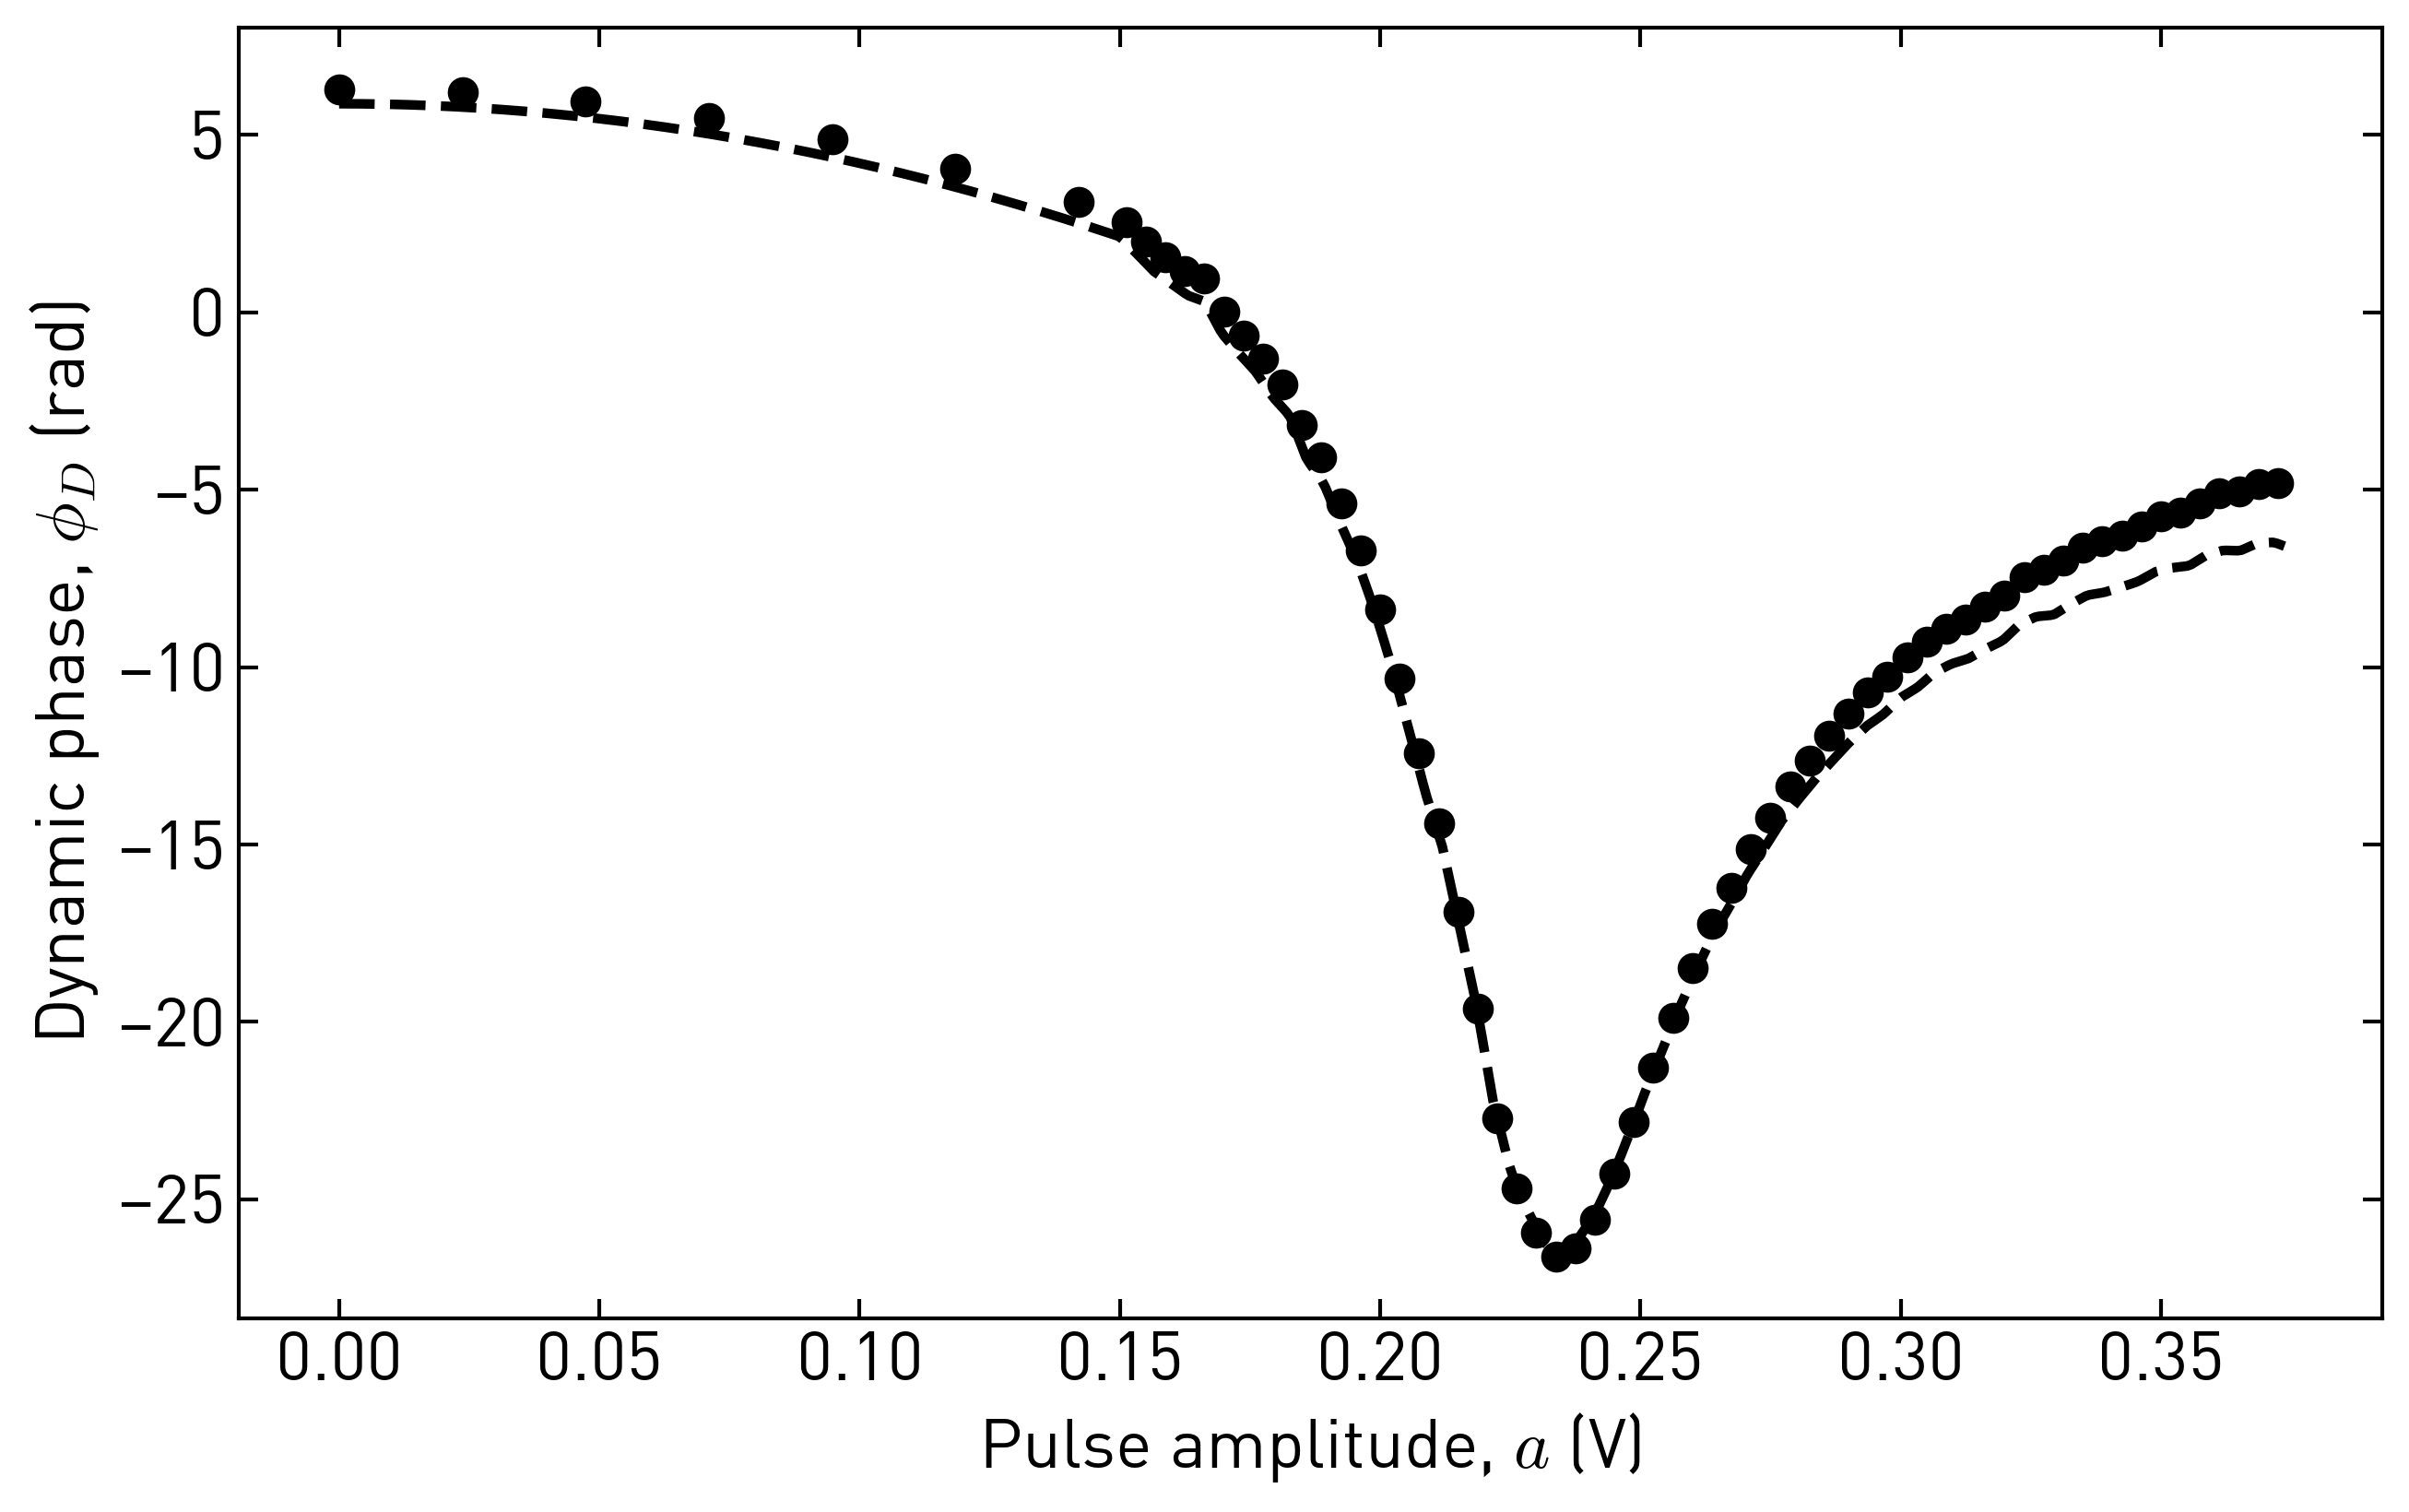

In [33]:
# plot
plt.plot(ampl, np.unwrap(dyn_phases_model/180*np.pi), color='k', linestyle='--', zorder=-1)
plt.scatter(np.sort(amplitudes_dyn)[::3], np.unwrap(dph_qbc[np.argsort(amplitudes_dyn)][::3]/180*np.pi), 
            c='k', s=50)
# plt.xlim(1.4,1.45)
plt.ylabel("Dynamic phase, $\phi_D$ (rad)")
plt.xlabel("Pulse amplitude, $a$ (V)")

In [206]:
def find_ampl_spacing_for_exp(dyn_model, dyn_model_amplitudes, amin=0, amax=0.35, phase_sep=120, 
                              max_spacing=0.08, search_window_size=0.02):
    """
    Generates the array of amplitudes at which the dynamic phase should be evaluated in the experiment, 
    while ensuring the spacing between two phases will be equal to phase_sep (based on model dynamic phase and ampl)
    Args:
        amin (float): amplitude at which experiment should begin
        amax (float): amplitude at which experiment should end
        dyn_model (array): unwraped dynamic phase estimated from model (radian)
        dyn_model_amplitudes (array): array corresponding to the amplitudes at which dyn_model is evaluated
        phase_sep (float, array): max phase separation between two points (deg), can also be array shaped like dyn_model_amplitudes
        max_spacing (float): maximal spacing between two values (trucates gradient)
        search_window_size (float):  will search the max spacing for each amplitude in window: (a-search_window_size, a + search_window_size)
            to avoid undersampling around a if there is a narrow peak (due to noise) around a.
    """
    deriv_dphase_dV = np.abs(np.gradient(dyn_model*180/np.pi, np.diff(dyn_model_amplitudes)[0]))
    max_ampl_spacing = np.minimum(phase_sep / deriv_dphase_dV, np.ones_like(deriv_dphase_dV)*max_spacing)
    plt.plot(dyn_model_amplitudes, max_ampl_spacing)
    ampl = [amin] 
    while (ampl[-1] < amax):
        search_window_min = find_nearest(dyn_model_amplitudes, ampl[-1])
        search_window_max = find_nearest(dyn_model_amplitudes, ampl[-1] + max_ampl_spacing[search_window_min])
#         search_window_min =  find_nearest(dyn_model_amplitudes, ampl[-1] - search_window_size)
#         search_window_max = find_nearest(dyn_model_amplitudes, ampl[-1] + search_window_size)
        ampl.append(ampl[-1] + np.min(max_ampl_spacing[search_window_min:search_window_max]))
    return np.asarray(ampl)

62

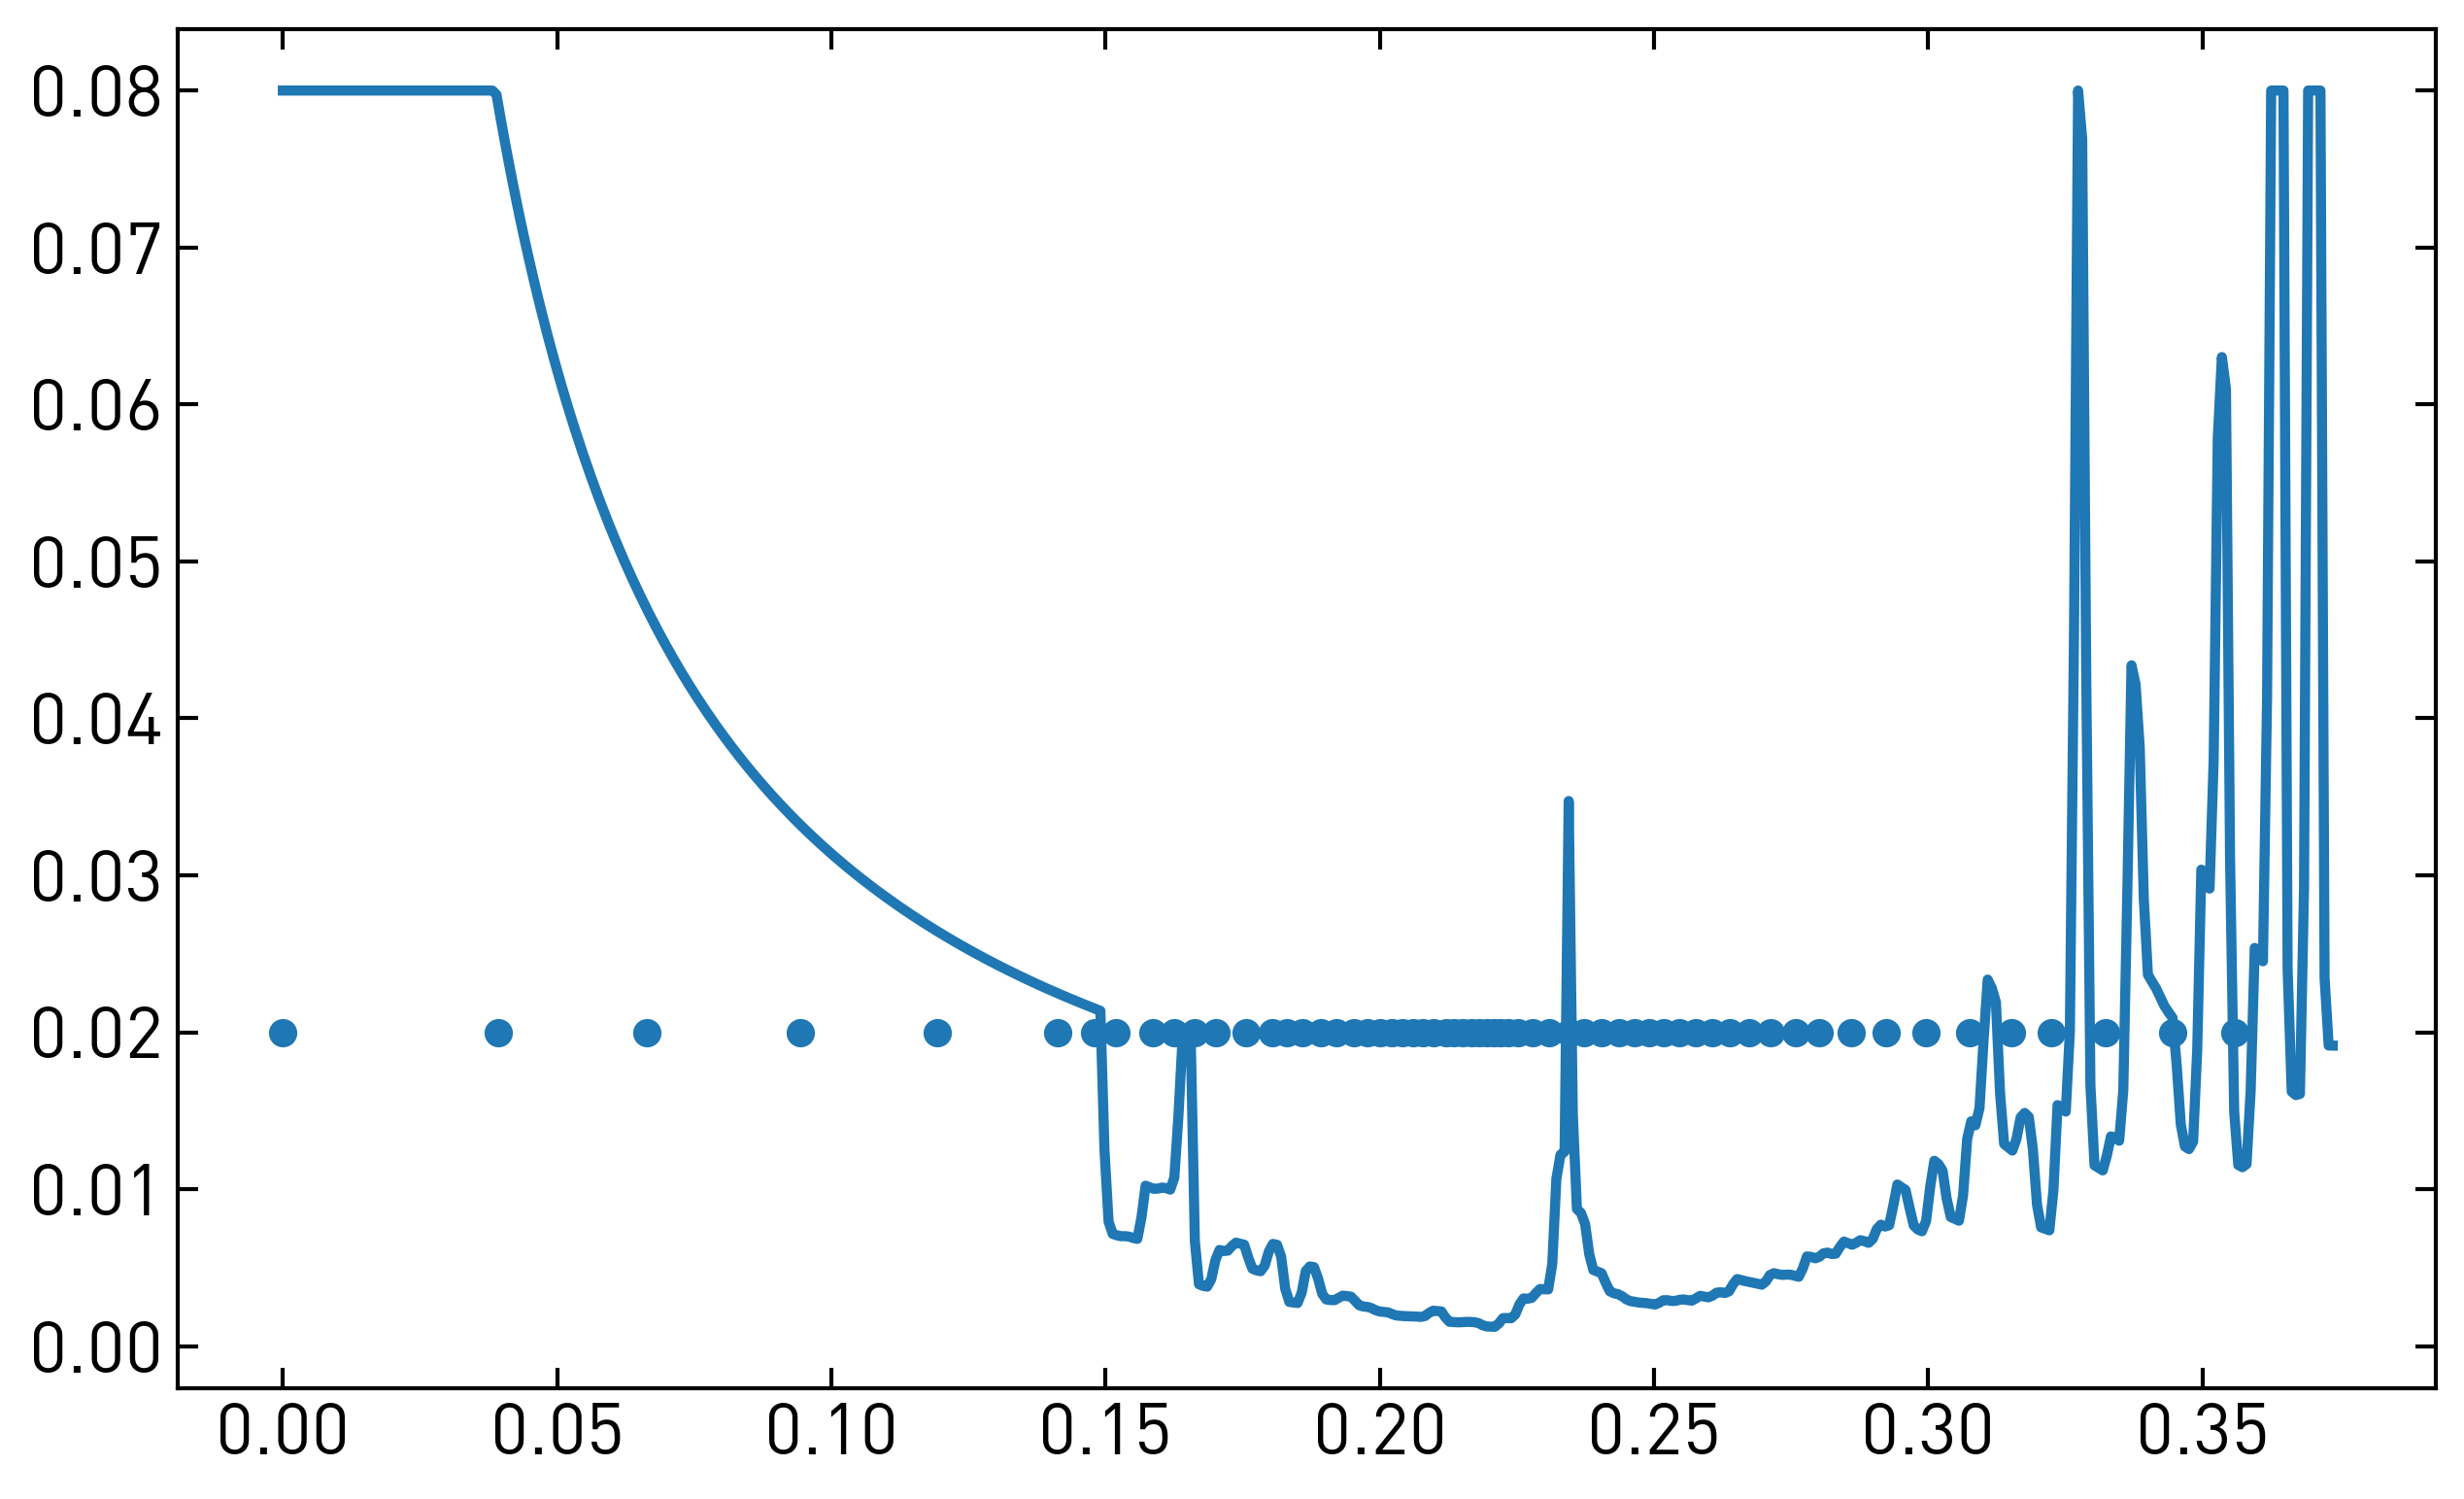

In [209]:
amp_exp = find_ampl_spacing_for_exp(np.unwrap(dyn_phases_model/180*np.pi), ampl, amin=0, phase_sep=60)
plt.scatter(amp_exp, np.ones_like(amp_exp)*0.02)
len(amp_exp)

### Pulse scheme 

In [213]:
qb3.upCZ_qb2_amplitude(qb3.upCZ_qb2_amplitude())

In [111]:
from pycqed.measurement.pulse_sequences import fluxing_sequences as fsqs
reload(segm)

qbc = qb3
qbt = qb2
cz_pulse_name = f"upCZ {qbt.name} {qbc.name}"
operation_dict = mqm.get_operation_dict([qbt, qbc])
hard_sweep_params = {
            'phase': {
                'values': np.tile(np.linspace(0, 2*np.pi, 6)*180/np.pi, 2),
                'unit': 'deg'}}
sequences = []
for a in [qb3.upCZ_qb2_amplitude()]:
    with gen.temporary_value(qbc.upCZ_qb2_amplitude, a):
        operation_dict = mqm.get_operation_dict([qbt, qbc])
        seq, sp = fsqs.dynamic_phase_seq(qbc.name, hard_sweep_params, operation_dict,
                              cz_pulse_name, cal_points=None, prepend_n_cz=0,
                              upload=False, prep_params=dict())
        sequences.append(seq)
        

In [114]:
%matplotlib inline
plot_style()

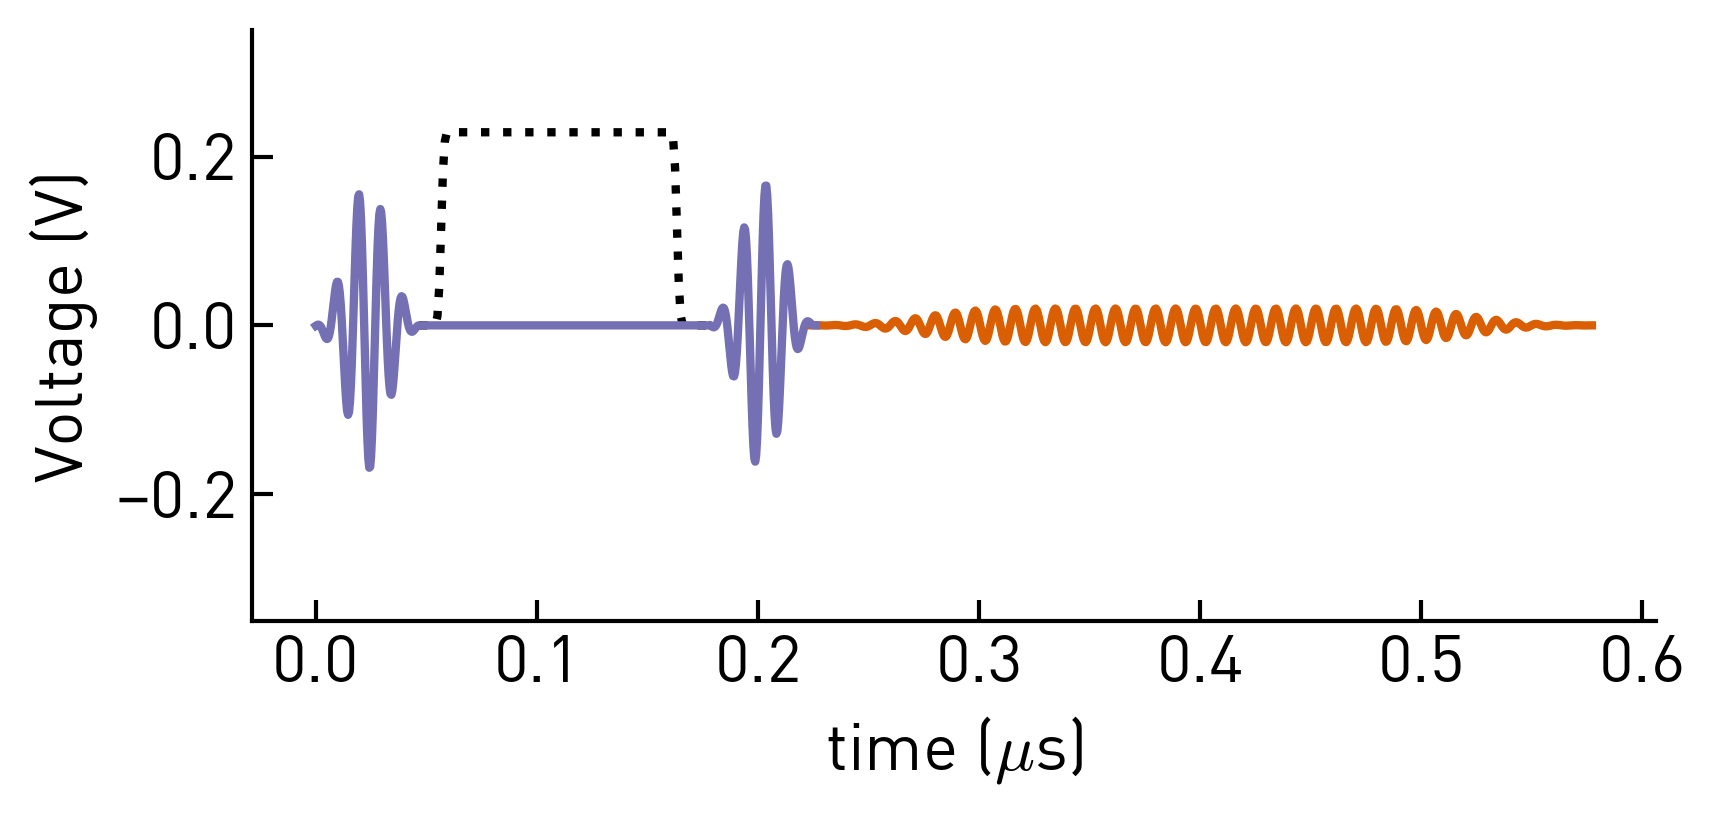

In [128]:
# plot pulse scheme 
# %matplotlib notebook
cmap = plt.get_cmap('Dark2')
qb_map = dict(qb3=['AWG8_ch5', "UHF_ch1", "AWG2_ch1"])
plot_kwargs=dict(linewidth=2)
for seq in sequences:
    fig, ax = plt.subplots(nrows=len(qb_map), figsize=(6, 3), squeeze=False, sharex=True)
    seq.segments["segment_0"].plot(axes=ax, channel_map=qb_map, frameon=dict(top=False, right=False), plot_kwargs=plot_kwargs,
                prop_cycle=dict(color=[cmap(0.21), 'k',  cmap(0.31)],
                               linestyle=['-', 'dotted', '-']), legend=False, demodulate=False)
    fig.suptitle("")
    ax[0,0].set_ylim([-0.35,0.35])
    plt.tick_params(top=False, right=False)

In [129]:
fig.savefig('ch4_carb_dyn_phase_pulse_scheme_qb3.png')

## All together

In [34]:
# find corresponding points of pulse lengths highlighted in cphase mnt for dyn phase measurement

indices_closest = []
for am in amplitudes[highlighted_selection]:
    indices_closest.append(find_nearest(np.sort(amplitudes_dyn)[::3], am))

In [44]:
360 - calc_cphase(0,
        qbc_freq_sweetspot=5.5315e+09, #qbc_freq_sweetspot, #5.53247417e+09, 
        qbc_anharmonicity= qbc.anharmonicity(), #qbc_anharmonicity, 
        qbt_ge_freq=qbt.ge_freq(),
        qbt_anharmonicity=qbt.anharmonicity(), #qbt_anharmonicity, 
       dphi_dv=dphi_dv, 
       J_00_10=J_00_10, #3.4e6, 
        ej_correction_factor=ej_correction_factor,
       flux_upwards=True) *180/pi

3.633321718712807

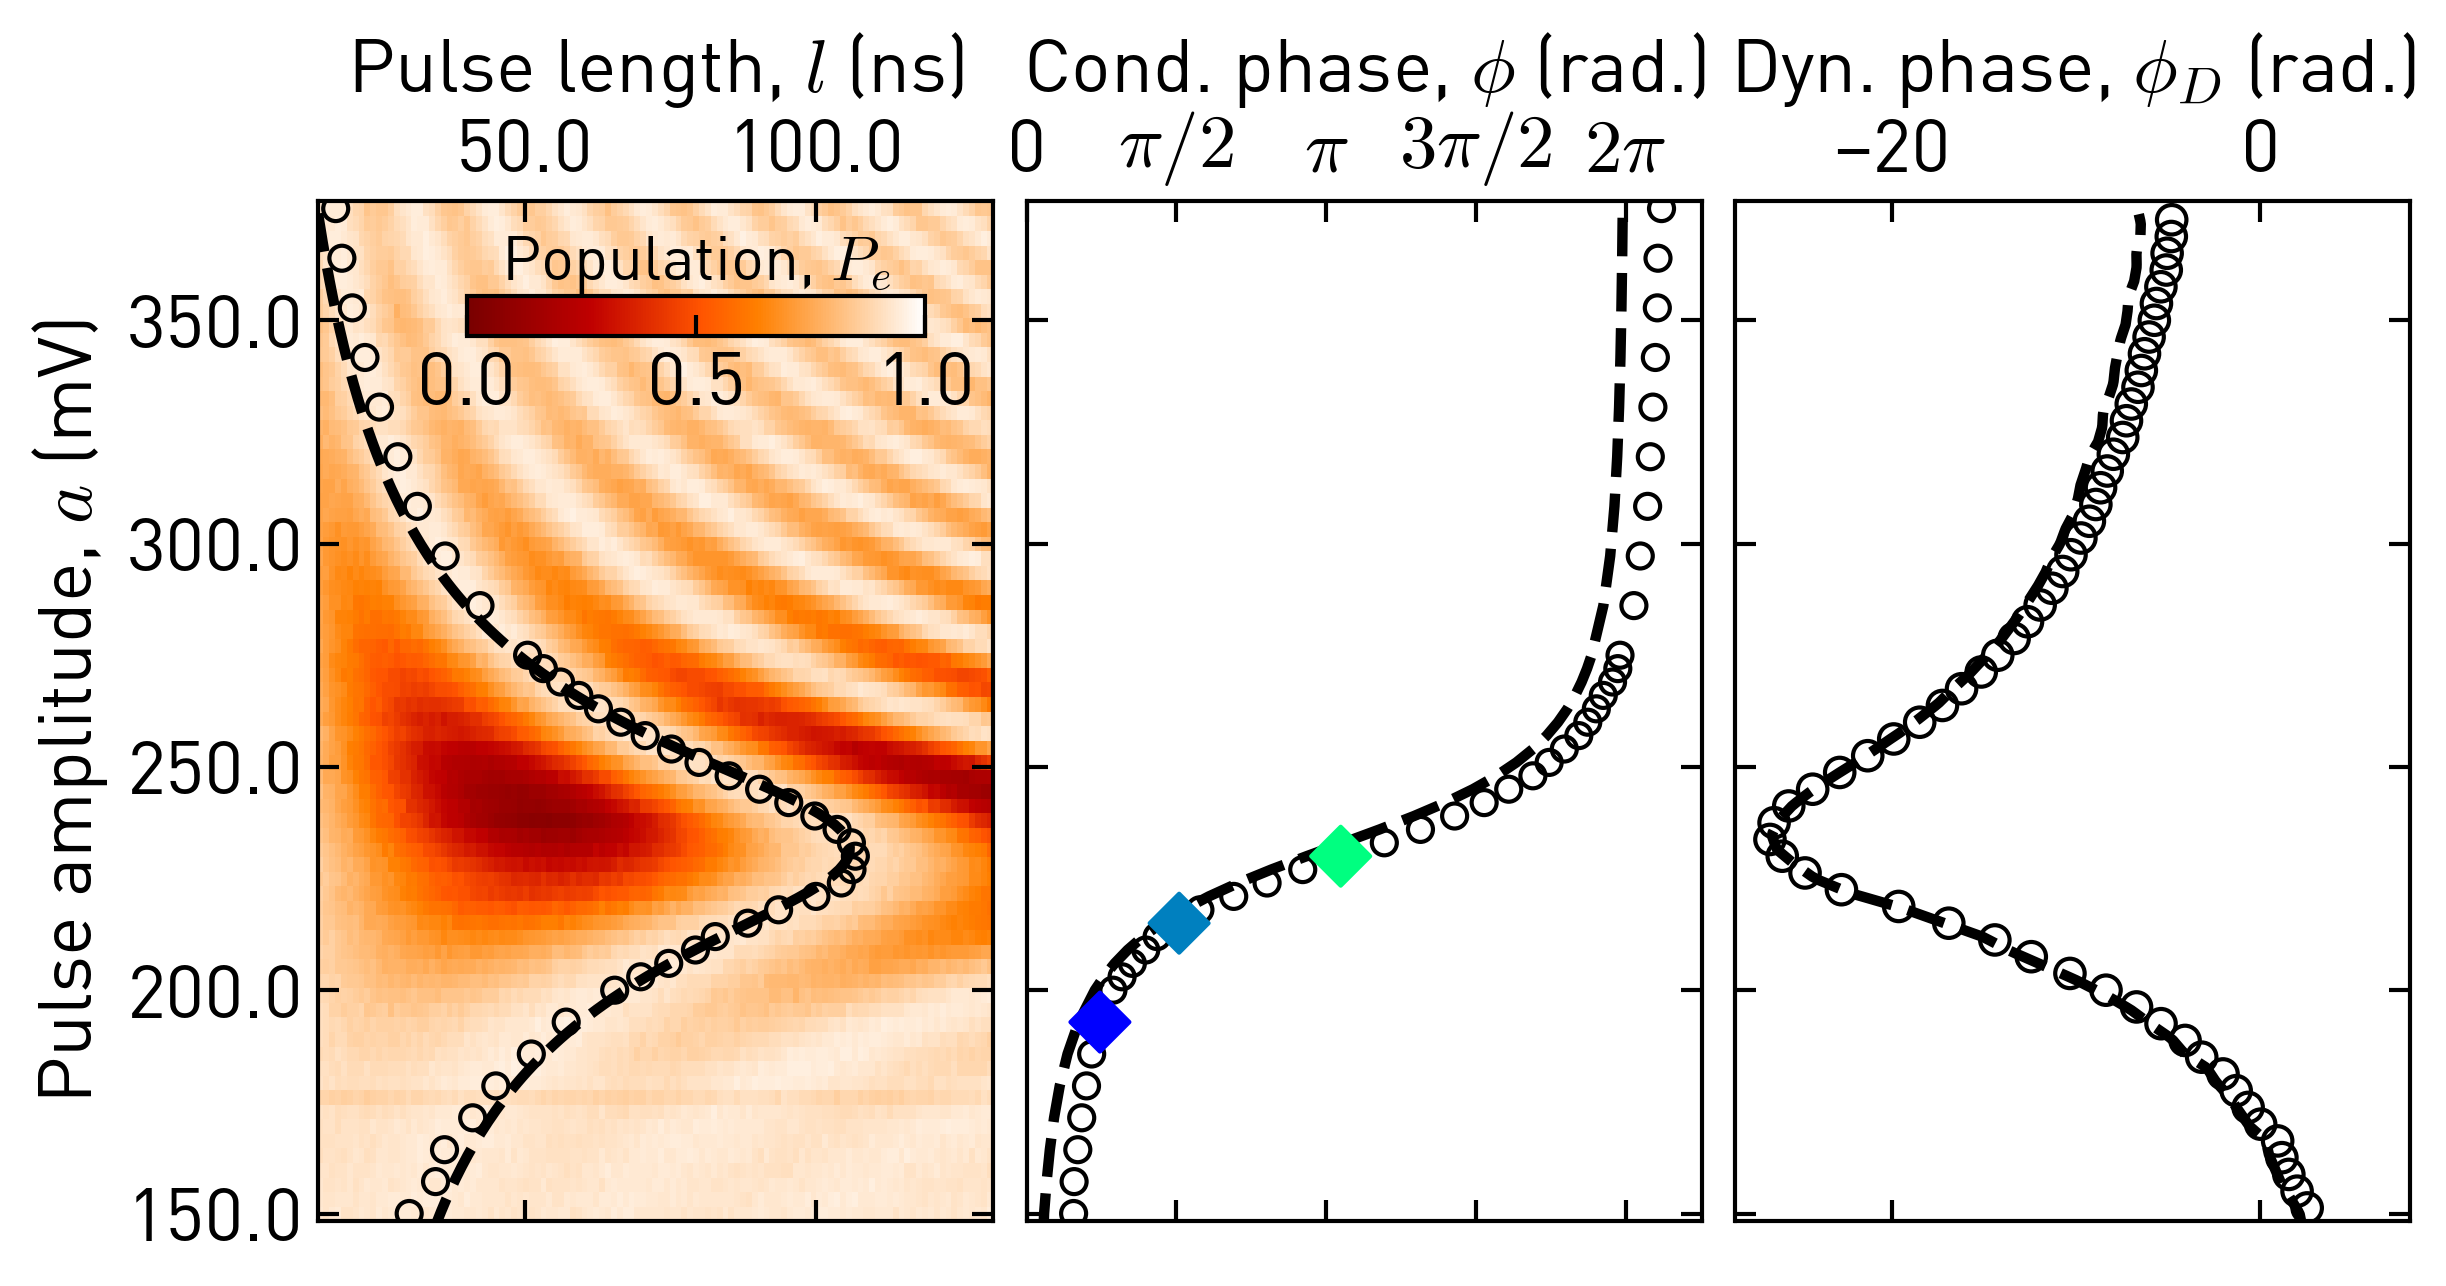

In [62]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(9,4.5))
plt.rcParams['xtick.direction'] ='in'
plt.rcParams['ytick.direction'] ='in'
# plot chevron
plotdict = dict(xvals=pulse_lengths,
               yvals=pulse_amplitudes/2, # because devides by two due to ppV in code (bug)
                   zvals=pe,
                    
                   xlabel='Pulse length, $l$', 
                    clabel=r'$|e\rangle$ Population, $p_e$',
                    ylabel='Pulse amplitude, $a$', xunit='s', yunit='V', 
                    plotcbar=False,
                    cmap=cmap_chevron, zrange=[0, 1])


a_chev.plot_colorxy(plotdict, ax[0])

# Now adding the colorbar
cbaxes = fig.add_axes([0.18, 0.78, 0.17, 0.03]) 
cb = plt.colorbar(ax[0].collections[0], ax=ax[0], cax=cbaxes, orientation="horizontal", ticks=[0,0.5,1])
cb.set_label('Population, $P_e$',fontsize=15)
# cbaxes.xaxis.set_ticks_position('top')
cbaxes.xaxis.set_label_position('top')

ax[0].plot(m.eval(a=ampl_fit_for_plot, **m.best_values), ampl_fit_for_plot, color='k', linestyle='--')
ax[0].scatter(times, amplitudes, marker="o",   zorder=3, edgecolor='k', facecolor='None')


# plot conditional phase
ax[1].scatter(cphases*radians, amplitudes, yunits=radians, edgecolor='k', facecolor='none', marker='o') #, c=[cmap((i % (2*np.pi))/(2*np.pi)) for i in cphases])
ax[1].scatter(cphases[highlighted_selection], amplitudes[highlighted_selection], marker="D", c=selection_color, 
           s=100, zorder=4)
# ax.axhline(0*radians, xunits=radians, linestyle='--', color='grey')
# ax.axhline(2*np.pi*radians, xunits=radians,linestyle='--', color='grey')
# ax.set_xlabel("Pulse amplitude, $a$ (V)")
ax[1].set_xlabel("Cond. phase, $\phi$ (rad.)")
ax[1].set_xlim([0, 2*np.pi + 0.8])
ax[1].set_xticks([0, np.pi/2, np.pi, np.pi/2*3, np.pi*2])

# ax[1].set_ylabel("Pulse amplitude, $a$ (V)")

#fit
J_00_10 = m.best_values['J_00_10'] # in Hz 
asym = m.best_values['d']
dphi_dv = m.best_values['dphi_dv']
cphases_model = calc_cphase(amplitudes,
        qbc_freq_sweetspot=5.5315e+09, #qbc_freq_sweetspot, #5.53247417e+09, 
        qbc_anharmonicity= qbc.anharmonicity(), #qbc_anharmonicity, 
        qbt_ge_freq=qbt.ge_freq(),
        qbt_anharmonicity=qbt.anharmonicity(), #qbt_anharmonicity, 
        junction_asym=asym,
       dphi_dv=dphi_dv, 
       J_00_10=J_00_10, #3.4e6, 
        ej_correction_factor=1,
       flux_upwards=True)
ax[1].plot((2*np.pi - cphases_model)*radians,amplitudes,  yunits=radians, linestyle='--', zorder=-1, color='k')
# plt.ylim([0, 2* np.pi])

# plot
ax[2].plot(np.unwrap(dyn_phases_model/180*np.pi), ampl, color='k', linestyle='--', zorder=-1)
ax[2].scatter( np.unwrap(dph_qbc[np.argsort(amplitudes_dyn)][::3]/180*np.pi), np.sort(amplitudes_dyn)[::3],
             s=50, edgecolor='k', facecolor='none')
# plt.xlim(1.4,1.45)
ax[2].set_xlabel("Dyn. phase, $\phi_D$ (rad.)")

plt.subplots_adjust(wspace=0.05)
for axx in ax.flatten():
    axx.xaxis.set_label_position('top')
#     axx.tick_params()
    axx.xaxis.set_ticks_position('top')
    axx.tick_params(bottom=True)
fig.align_labels(axs=ax)


In [63]:
fig.savefig(figsave_base+"ch4_carb_calibration_{:%Y%m%d_%H%M%S}.png".format(datetime.now()))

In [71]:
cphases[highlighted_selection]*180/np.pi

array([ 43.98876612,  91.61607312, 188.76274082])

# Characterization

## Process tomography

See separate notebook in ./ressources/process_tomo_analysis.ipynb

## Conditional and Dynamic phase errors

See notebook in ./ressources/cphi_characterization.ipynb

## Comparizon CZ CARB

See notebook in ./ressources/cphi_characterization.ipynb

In [258]:
# average flux pulse length carb
np.mean(times)

6.124191170020492e-08

In [259]:
0.10973013592466616 - 0.025

0.08473013592466616